In [2]:
# Importamos librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import scipy.stats as stats

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Escalado de features
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

In [4]:
# Realizamos una función que aplique Box-Cox a los valores para ver si mejora un poco la distribución
def bc_transf(feature):
    bc = PowerTransformer(method='box-cox')
    feat_bc = bc.fit_transform(playlist[feature].values.reshape((750,1)))
    feat_bc = pd.DataFrame(feat_bc)
    feat_bc.hist()
    plt.title(f"El feature {feature} con Box-Cox tiene skewness {feat_bc.skew()}")
    return feat_bc

In [5]:
# Como es negativo, vamos a crear un Yeo-Johnson transformer
def yj_transf(feature):
    yj = PowerTransformer(method='yeo-johnson')
    feat_yj = yj.fit_transform(playlist[feature].values.reshape((750,1)))
    feat_yj = pd.DataFrame(feat_yj)
    feat_yj.hist()
    plt.title(f"El feature {feature} con Yeo-Johnson tiene skewness {feat_yj.skew()}")
    return feat_yj

### Análisis de Spotify
Preguntas interesantes para considerar:
- El objetivo es poder estimar si un tema nuevo del gusto de la persona que tiene esta playlist activa. En este caso la variable label corresponde a nuestra variable de salida a analizar

In [6]:
# Análisis exploratorio inicial
playlist = pd.read_csv('data_playlist.csv')
playlist.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
0,0.713,0.514,100125,0.521,0.816000,8,0.1120,-14.835,0,0.0444,119.879,4,0.143,1
1,0.192,0.714,207019,0.614,0.000000,4,0.2630,-6.935,1,0.0319,123.969,4,0.582,1
2,0.333,0.630,216200,0.455,0.000004,5,0.1270,-9.290,1,0.0292,139.931,4,0.199,1
3,0.601,0.810,136413,0.221,0.210000,5,0.1840,-11.005,1,0.0429,109.960,4,0.798,1
4,0.883,0.465,181440,0.459,0.000173,6,0.0692,-8.137,0,0.0351,90.807,4,0.288,1


In [7]:
playlist.isnull().sum()

acousticness        0
danceability        0
duration            0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
label               0
dtype: int64

In [8]:
# Vemos primero el tipo de información que tiene cada variable
print("columnas, filas: ", playlist.shape, "\n")
playlist.info()

columnas, filas:  (750, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      750 non-null    float64
 1   danceability      750 non-null    float64
 2   duration          750 non-null    int64  
 3   energy            750 non-null    float64
 4   instrumentalness  750 non-null    float64
 5   key               750 non-null    int64  
 6   liveness          750 non-null    float64
 7   loudness          750 non-null    float64
 8   mode              750 non-null    int64  
 9   speechiness       750 non-null    float64
 10  tempo             750 non-null    float64
 11  time_signature    750 non-null    int64  
 12  valence           750 non-null    float64
 13  label             750 non-null    int64  
dtypes: float64(9), int64(5)
memory usage: 82.2 KB


- Revisamos el detalle de los features del dataset: [Spotify for Developers](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features)

De `.info()` podemos sacar que:
- No existen valores no nulos, por lo tanto, no habría que rellenarlos.
- Todos los features son numéricos, aunque no podríamos especificar el tipo todavía.

#### Acousticness

- A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

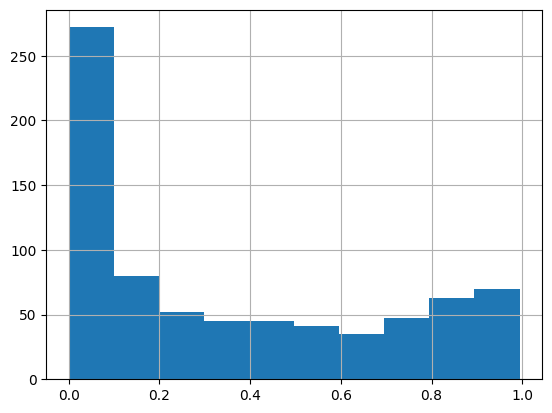

In [9]:
playlist.acousticness.hist();

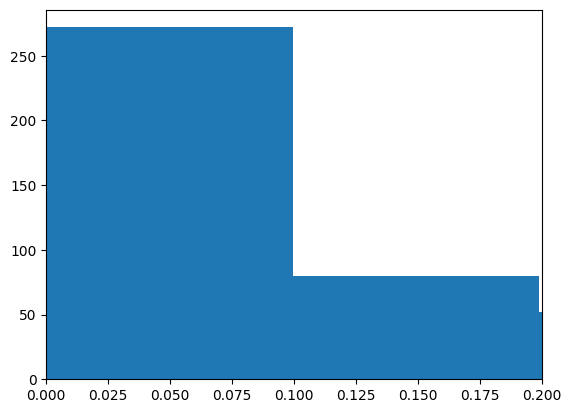

In [10]:
# Hacemos un zoom cerca en el rango 0.0-0.2:
plt.hist(x=playlist.acousticness, bins=10)
plt.xlim(left=0.0, right=0.2)
plt.show()

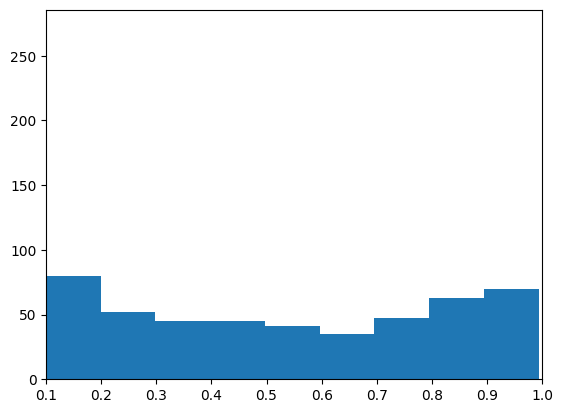

In [11]:
# Hacemos un zoom cerca en el rango 0.0-0.2:
plt.hist(x=playlist.acousticness, bins=10)
plt.xlim(left=0.1, right=1.0)
plt.show()

- La gran mayoría de valores se encuentran debajo de 0.1.
- El resto puede considerarse distribuido de manera uniforme.

In [12]:
playlist.acousticness.value_counts().sort_values(ascending=False)

acousticness
0.99200    7
0.99000    5
0.58600    4
0.19400    4
0.74100    4
          ..
0.03850    1
0.00419    1
0.04350    1
0.50600    1
0.01550    1
Name: count, Length: 596, dtype: int64

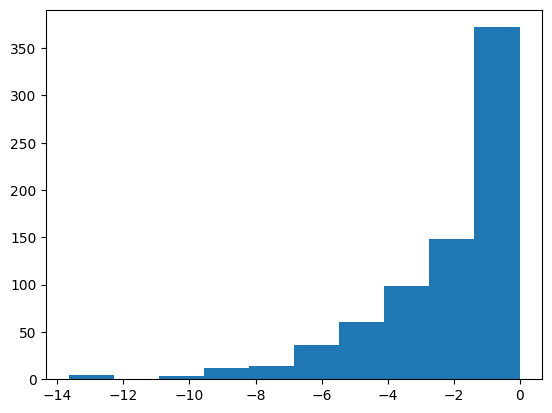

In [222]:
# Planteamos una transformación logaritmica
playlist['log_ac'] = np.log(playlist.acousticness.values)
plt.hist(playlist['log_ac'], bins=10);

,0
0,1.006932
1,-0.159184
2,0.211746
3,0.784129
4,1.344324
...,...
745,-1.806222
746,-1.491478
747,1.410637
748,-0.234211


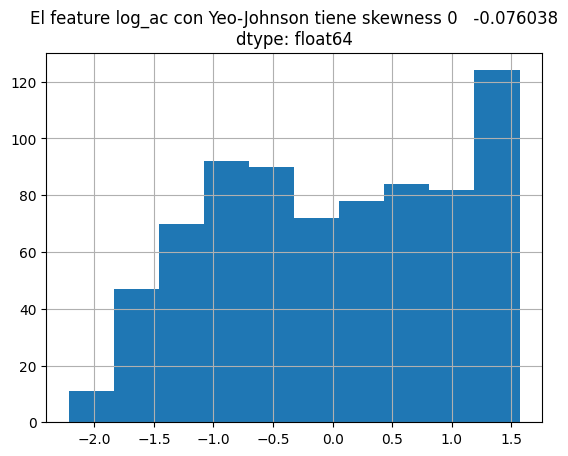

In [14]:
# Pasamos Yeo-Johnson
yj_transf('log_ac')

- Valores continuos entre 0 y 1.
- La mayoría de los valores son bajos.
- A priori, no tiene una distribución conocida.
- ¿Existe alguna manera de explicar haciendo binning?
- ¿Sirve enmascarar la columna en valores menores y mayores a 0.1 para darle un punto de vista de feature categórico?

#### Danceability

- Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

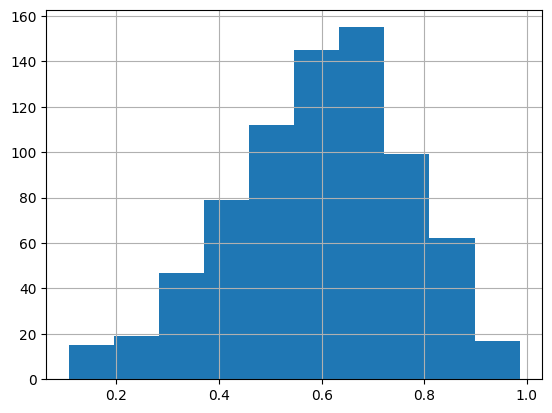

In [15]:
playlist.danceability.hist();

In [16]:
from sklearn.preprocessing import PowerTransformer

In [17]:
# Aplicamos Box-Cox a los valores para ver si mejora un poco la distribución
bc = PowerTransformer(method='box-cox')
danc_bc = bc.fit_transform(playlist.danceability.values.reshape((750,1)))

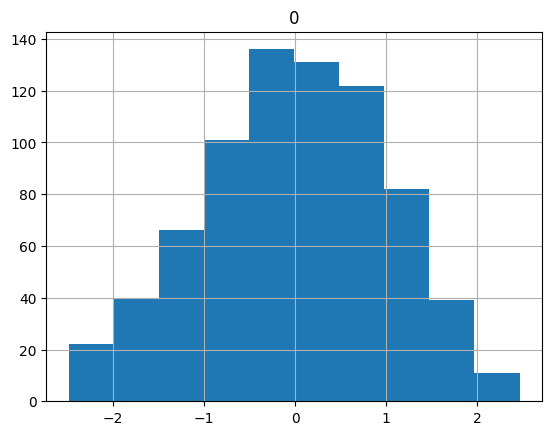

In [18]:
danc_bc = pd.DataFrame(danc_bc)
danc_bc.hist();

In [19]:
# Calculamos el skewness
danc_bc.skew()

0   -0.08915
dtype: float64

- Valores continuos entre 0 y 1.
- Tiene skewness.
- Mejora el skewness luego de una transformación con Box-Cox.

#### Duration

- The duration of the track in milliseconds.

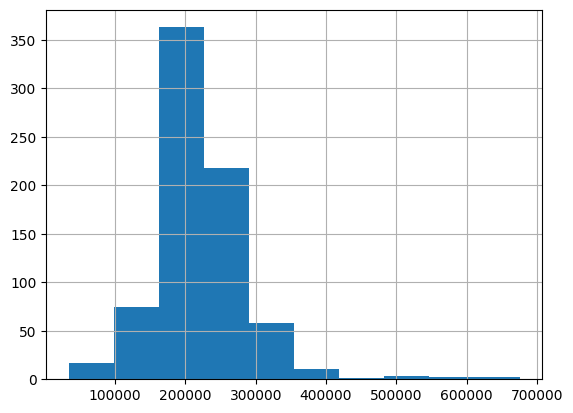

In [20]:
playlist.duration.hist();

In [21]:
# Vemos el skewness inicial
playlist.duration.skew()

1.5762310506305088

In [22]:
playlist.duration.kurt()

8.321863173473714

,0
0,-2.175365
1,-0.130681
2,0.015353
3,-1.390479
4,-0.556411
...,...
745,1.656701
746,-0.035172
747,-1.605952
748,0.519389


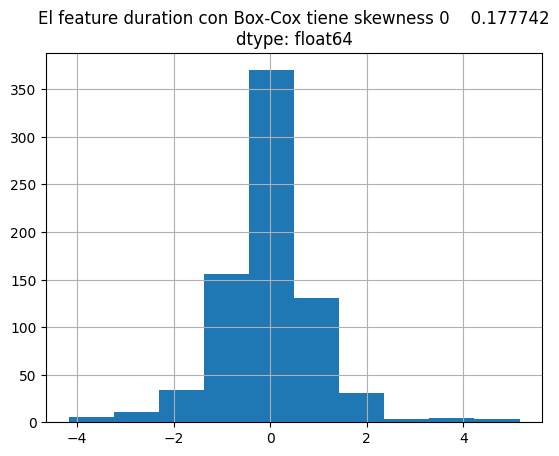

In [23]:
bc_transf('duration')

- Se ve una mejora en el skewness de la pieza luego de la transformación.

#### Energy

- Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

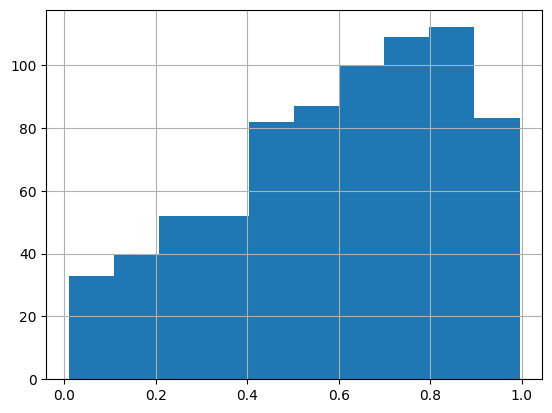

In [24]:
playlist.energy.hist();

In [25]:
playlist.energy.skew(), playlist.energy.kurt()

(-0.4587645952079551, -0.7589617649784031)

,0
0,-0.331216
1,0.043670
2,-0.591460
3,-1.463659
4,-0.575837
...,...
745,1.431606
746,1.103544
747,-1.128036
748,0.915508


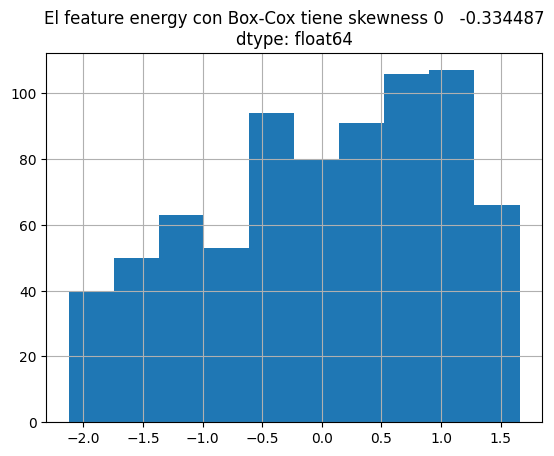

In [26]:
# Analizamos lo mismo en esta feature
bc_transf('energy')

#### Instrumentalness

- Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

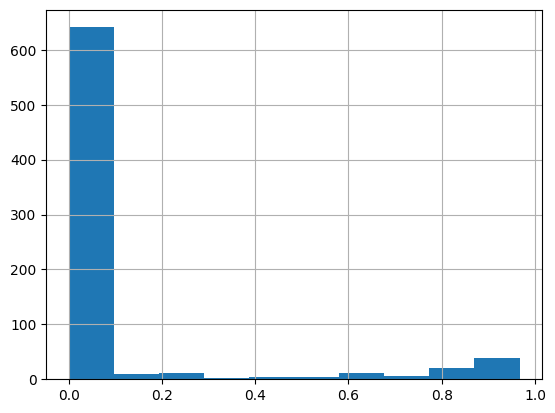

In [27]:
playlist.instrumentalness.hist();

In [28]:
playlist.instrumentalness.value_counts().sort_values(ascending=False)

instrumentalness
0.000000    290
0.000010      3
0.000229      3
0.872000      3
0.000006      2
           ... 
0.000002      1
0.005310      1
0.002230      1
0.520000      1
0.003140      1
Name: count, Length: 431, dtype: int64

In [29]:
inst_cero = playlist.instrumentalness[playlist['instrumentalness'] != 0.0].count()
instr_no_cero = playlist.instrumentalness[playlist['instrumentalness'] == 0.0].count()

In [30]:
print(f'Instrumentalness = 0 / instrumentalness dist 0: {instr_no_cero/inst_cero:.3f}') # se puede decir que está balanceado

Instrumentalness = 0 / instrumentalness dist 0: 0.630


#### Key

- The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

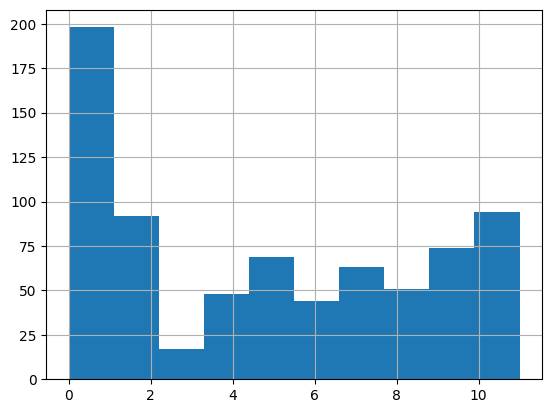

In [31]:
playlist.key.hist();

In [32]:
playlist.key.value_counts().sort_values(ascending=False)

key
0     113
2      92
1      85
9      74
5      69
7      63
8      51
4      48
10     48
11     46
6      44
3      17
Name: count, dtype: int64

#### Liveness

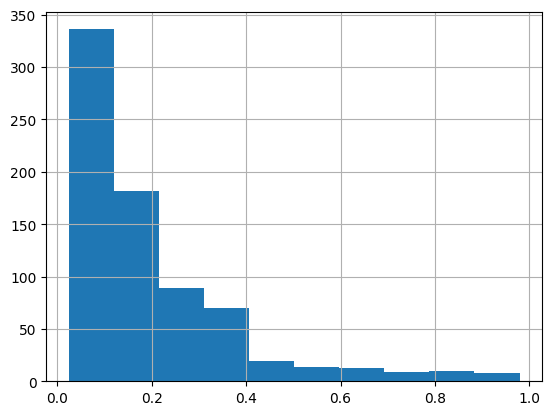

In [33]:
playlist.liveness.hist();

In [34]:
playlist.liveness.skew()

2.1562404755479365

,0
0,-0.389576
1,0.827661
2,-0.189134
3,0.357849
4,-1.235416
...,...
745,-0.214012
746,-0.632363
747,1.195898
748,-0.252327


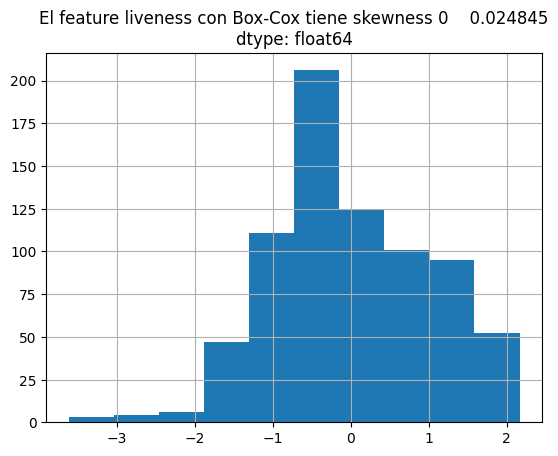

In [35]:
# Transformamos la feature con Box-Cox:
bc_transf('liveness')

#### Loudness

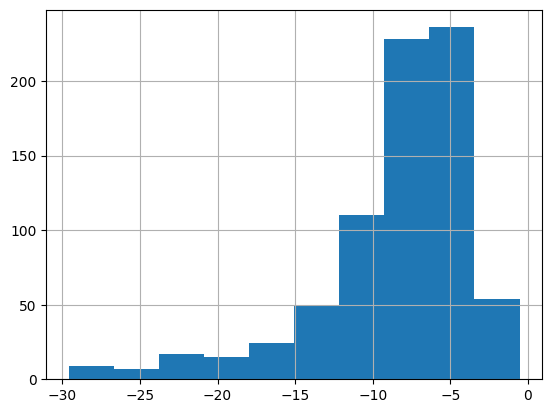

In [36]:
playlist.loudness.hist();

In [37]:
playlist.loudness.skew()

-1.6931146926686604

,0
0,-1.303451
1,0.100206
2,-0.445834
3,-0.759268
4,-0.198927
...,...
745,1.078487
746,1.483683
747,-0.078905
748,0.111864


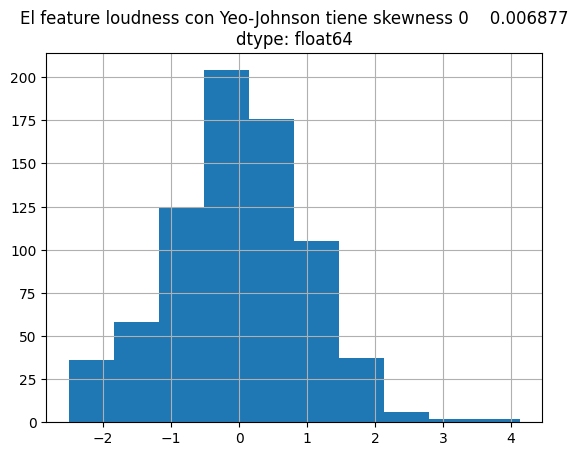

In [38]:
yj_transf('loudness')

- Mejora notablemente.

#### Mode

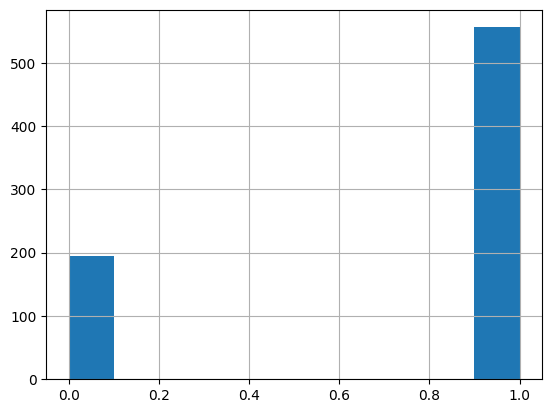

In [39]:
playlist['mode'].hist();

In [40]:
playlist['mode'].value_counts()

mode
1    556
0    194
Name: count, dtype: int64

#### Speechiness

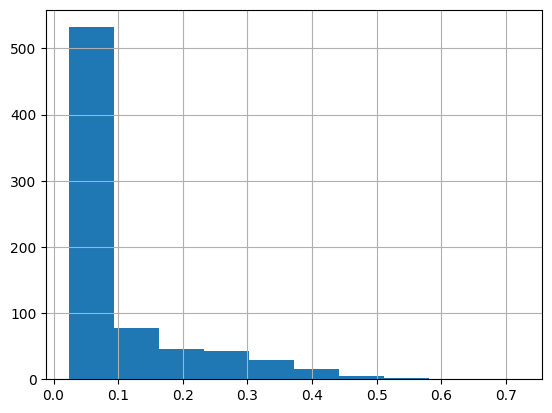

In [41]:
playlist.speechiness.hist();

In [42]:
playlist.speechiness.skew()

2.0403697815970148

,0
0,-0.376482
1,-1.085454
2,-1.306022
3,-0.442445
4,-0.862557
...,...
745,0.016599
746,-0.021765
747,-1.026195
748,-0.728710


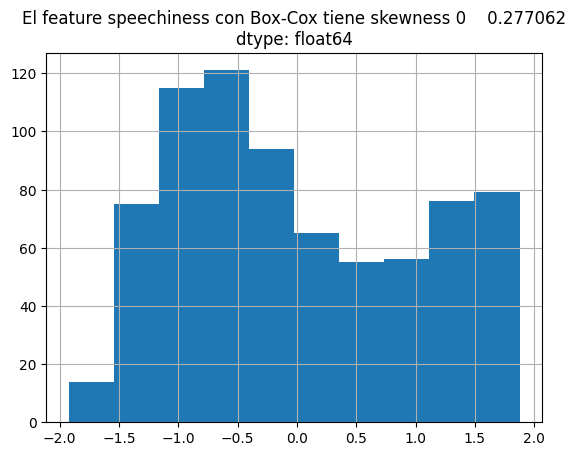

In [43]:
bc_transf('speechiness')

- Se ve también una mejora en la transformación.

#### Tempo

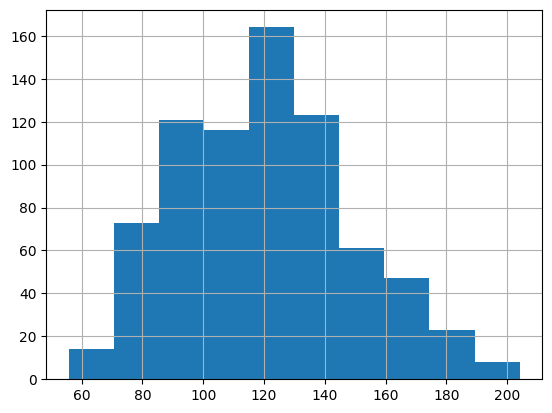

In [44]:
playlist.tempo.hist();

In [45]:
playlist.tempo.skew()

0.3347625436886502

,0
0,0.055777
1,0.198307
2,0.727922
3,-0.303071
4,-1.058360
...,...
745,-0.224569
746,1.343860
747,0.670711
748,0.858672


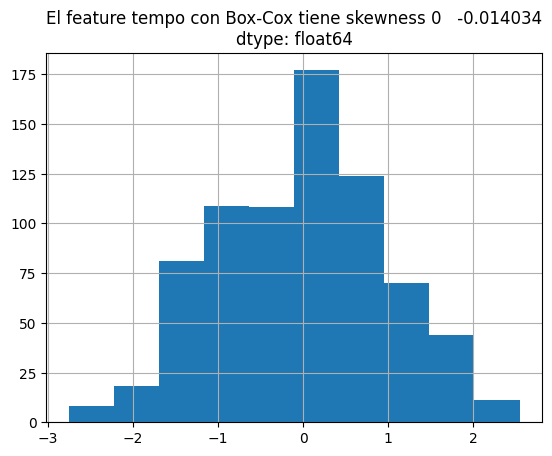

In [46]:
bc_transf('tempo')

#### Time Signature

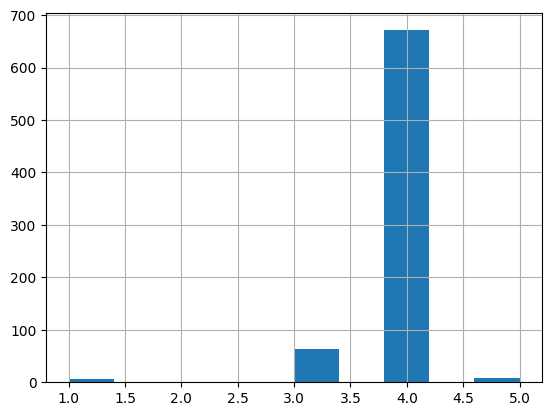

In [47]:
playlist.time_signature.hist();

In [48]:
playlist.time_signature.value_counts()

time_signature
4    671
3     64
5      9
1      6
Name: count, dtype: int64

In [49]:
len(playlist)

750

In [50]:
# Podemos ver etiquetas poco frecuentes
ts_no_4 = playlist.time_signature[playlist.time_signature != 4].sum()
ts_4 = playlist.time_signature[playlist.time_signature == 4].sum()

print(f'Time Signature 4 / Time Signature no 4: {ts_no_4 / ts_4:3f}')

Time Signature 4 / Time Signature no 4: 0.090537


#### Valence

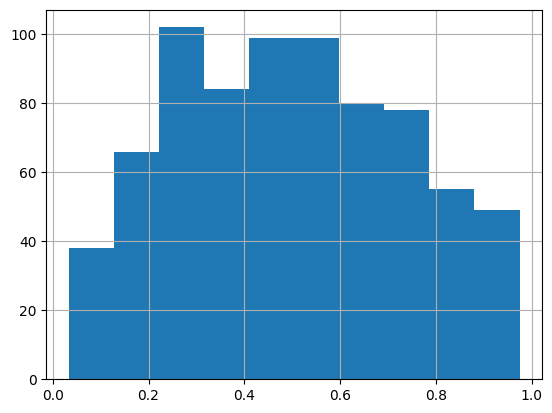

In [51]:
playlist.valence.hist();

In [52]:
playlist.valence.skew()

0.10481159565511211

#### Label

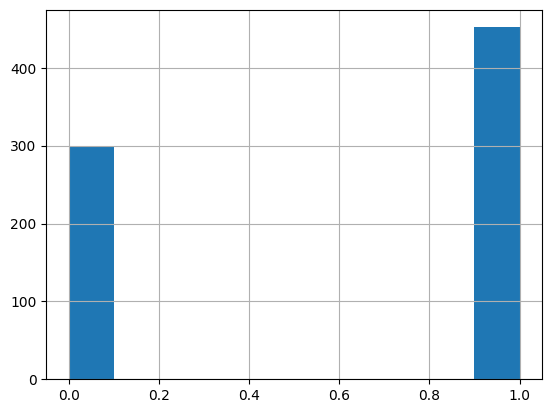

In [53]:
playlist.label.hist();

In [54]:
playlist.label.value_counts()

label
1    452
0    298
Name: count, dtype: int64

- Si bien existe una diferencia entre los dos labels, se puede decir que no está desbalanceado.

## Análisis detallado

In [55]:
playlist.describe()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label,log_ac
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,0.357394,0.596439,220112.733333,0.594188,0.100245,4.829333,0.203376,-8.509339,0.741333,0.098966,120.405761,3.902667,0.497321,0.602667,-2.179553
std,0.338405,0.172036,65587.690483,0.253301,0.259921,3.636001,0.177609,5.039488,0.438194,0.104715,28.378116,0.400091,0.239615,0.489673,2.293834
min,0.000001,0.107000,33840.000000,0.009250,0.000000,0.000000,0.024000,-29.601000,0.000000,0.023400,55.747000,1.000000,0.033200,0.000000,-13.658507
25%,0.037150,0.480000,185490.250000,0.423250,0.000000,1.000000,0.094550,-10.173500,0.000000,0.035900,98.998000,4.000000,0.297000,0.000000,-3.292794
50%,0.244500,0.606000,215108.500000,0.631500,0.000010,5.000000,0.129000,-7.270000,1.000000,0.048750,120.104500,4.000000,0.483000,1.000000,-1.408559
75%,0.678500,0.715750,244236.750000,0.804750,0.002245,8.000000,0.264750,-5.097750,1.000000,0.113000,138.074750,4.000000,0.684500,1.000000,-0.387872
max,0.994000,0.986000,675360.000000,0.995000,0.967000,11.000000,0.979000,-0.533000,1.000000,0.721000,204.162000,5.000000,0.975000,1.000000,-0.006018


In [56]:
numericas_total = ['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness','liveness', 'loudness', 'speechiness', 'tempo', 'valence']
numericas = ['danceability', 'duration', 'energy', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
categoricas = ['key', 'mode', 'time_signature']

In [57]:
playlist[numericas].skew().sort_values()

loudness       -1.693115
energy         -0.458765
danceability   -0.311981
valence         0.104812
tempo           0.334763
duration        1.576231
speechiness     2.040370
liveness        2.156240
dtype: float64

In [58]:
# Usamos una función útil para ver todas las distribuciones
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

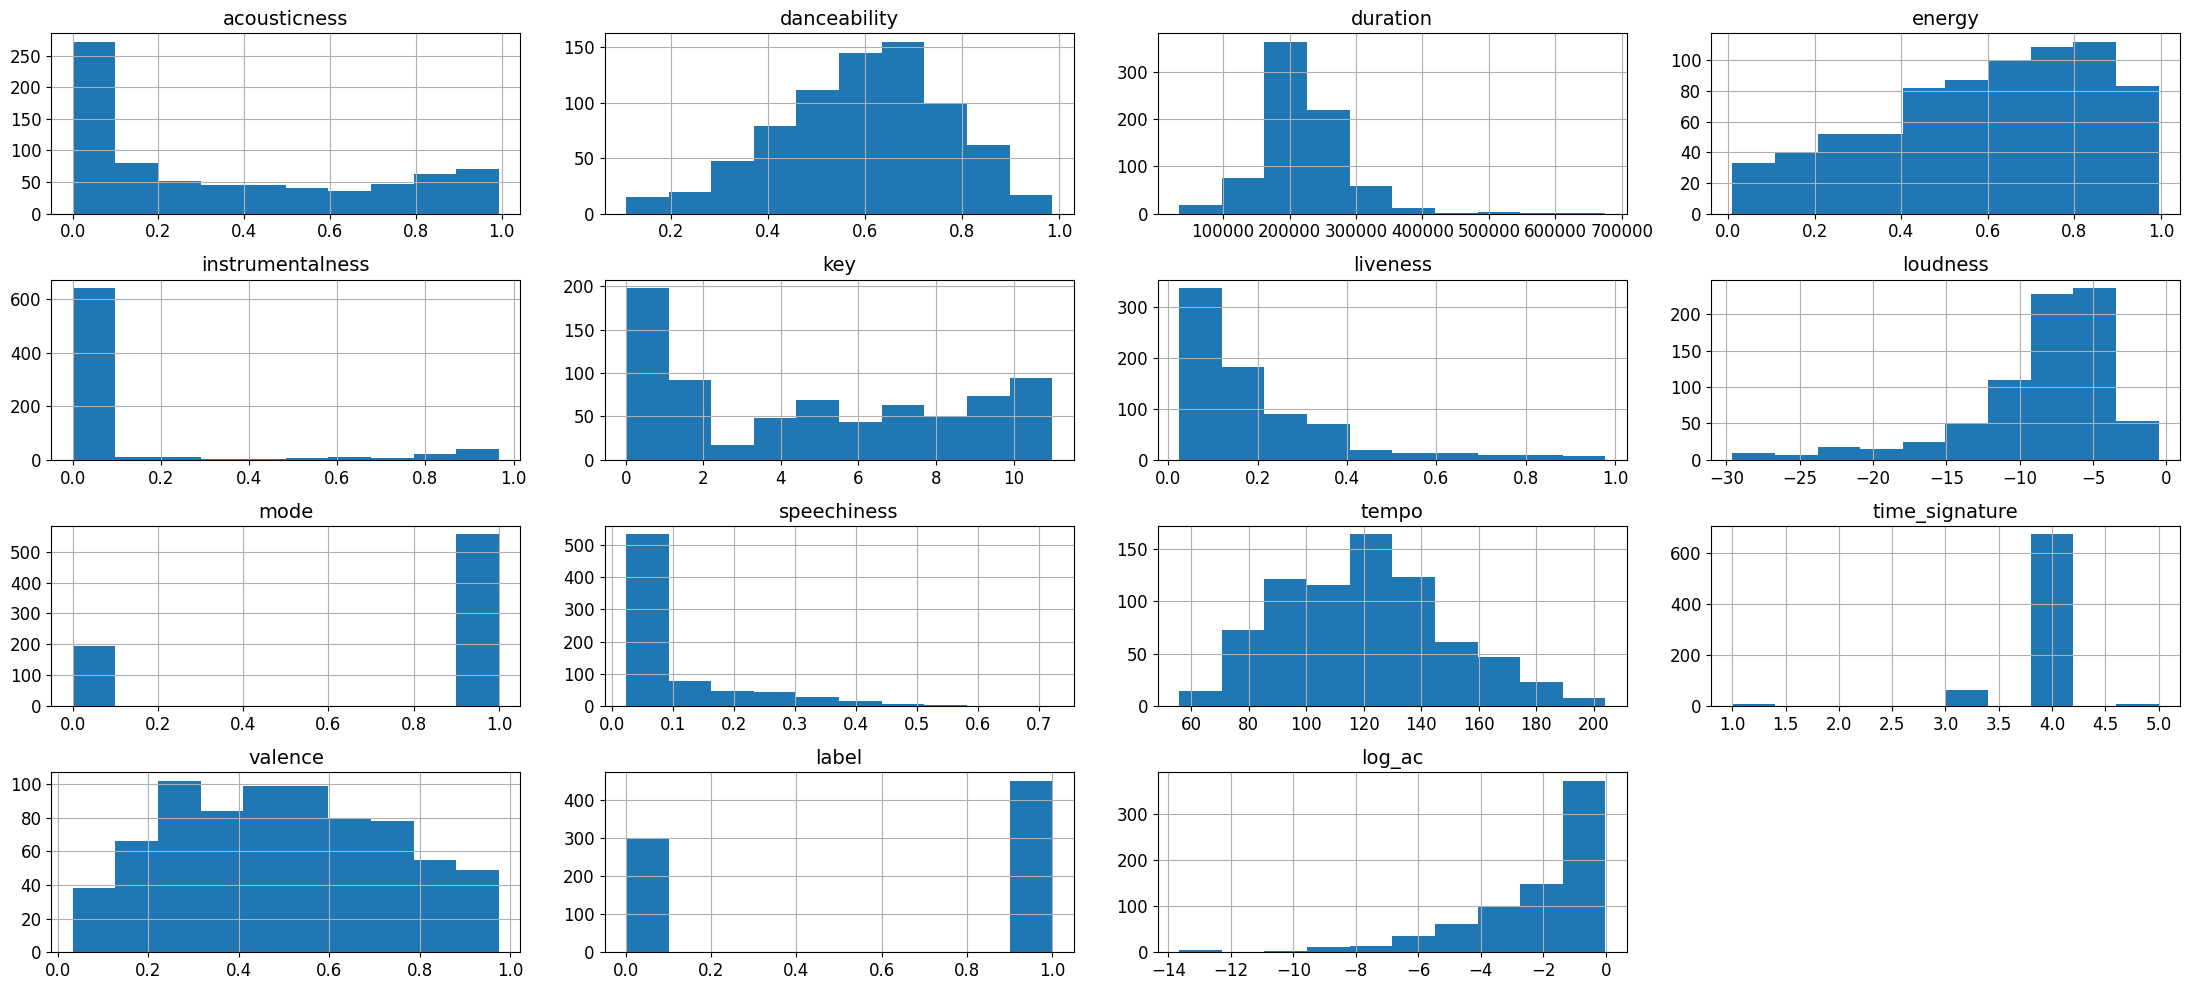

In [59]:
display_dataset_distributions(playlist)

In [60]:
# Vemos como está la correlación de las variables
playlist.corr()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label,log_ac
acousticness,1.000000,-0.417974,0.054988,-0.781691,0.331659,-0.065184,-0.140326,-0.695163,0.111980,-0.215614,-0.149472,-0.205854,-0.233485,0.479307,0.760346
danceability,-0.417974,1.000000,-0.231120,0.360971,-0.238865,0.055302,-0.115735,0.396021,-0.058461,0.272283,0.064002,0.222486,0.483361,-0.368501,-0.171055
duration,0.054988,-0.231120,1.000000,-0.093435,0.161803,-0.002089,-0.002576,-0.179952,-0.011989,-0.110645,-0.052321,-0.003030,-0.256984,0.138562,0.004552
energy,-0.781691,0.360971,-0.093435,1.000000,-0.267846,0.066970,0.235887,0.830081,-0.102567,0.173371,0.197741,0.241667,0.364495,-0.459088,-0.609573
instrumentalness,0.331659,-0.238865,0.161803,-0.267846,1.000000,-0.020726,-0.050720,-0.429529,-0.032180,-0.145104,-0.081531,-0.024597,-0.228774,0.133523,0.010533
key,-0.065184,0.055302,-0.002089,0.066970,-0.020726,1.000000,-0.055710,0.009126,-0.158468,0.081137,-0.084476,0.096863,0.068146,-0.075631,-0.019924
liveness,-0.140326,-0.115735,-0.002576,0.235887,-0.050720,-0.055710,1.000000,0.154176,-0.023585,0.106747,-0.008093,0.037201,0.051110,-0.108682,-0.153085
loudness,-0.695163,0.396021,-0.179952,0.830081,-0.429529,0.009126,0.154176,1.000000,-0.048111,0.188873,0.188127,0.169130,0.294852,-0.424345,-0.491215
mode,0.111980,-0.058461,-0.011989,-0.102567,-0.032180,-0.158468,-0.023585,-0.048111,1.000000,-0.118390,0.013911,-0.044799,0.051939,0.080375,0.069978
speechiness,-0.215614,0.272283,-0.110645,0.173371,-0.145104,0.081137,0.106747,0.188873,-0.118390,1.000000,0.139993,0.088062,0.101257,-0.480931,-0.147318


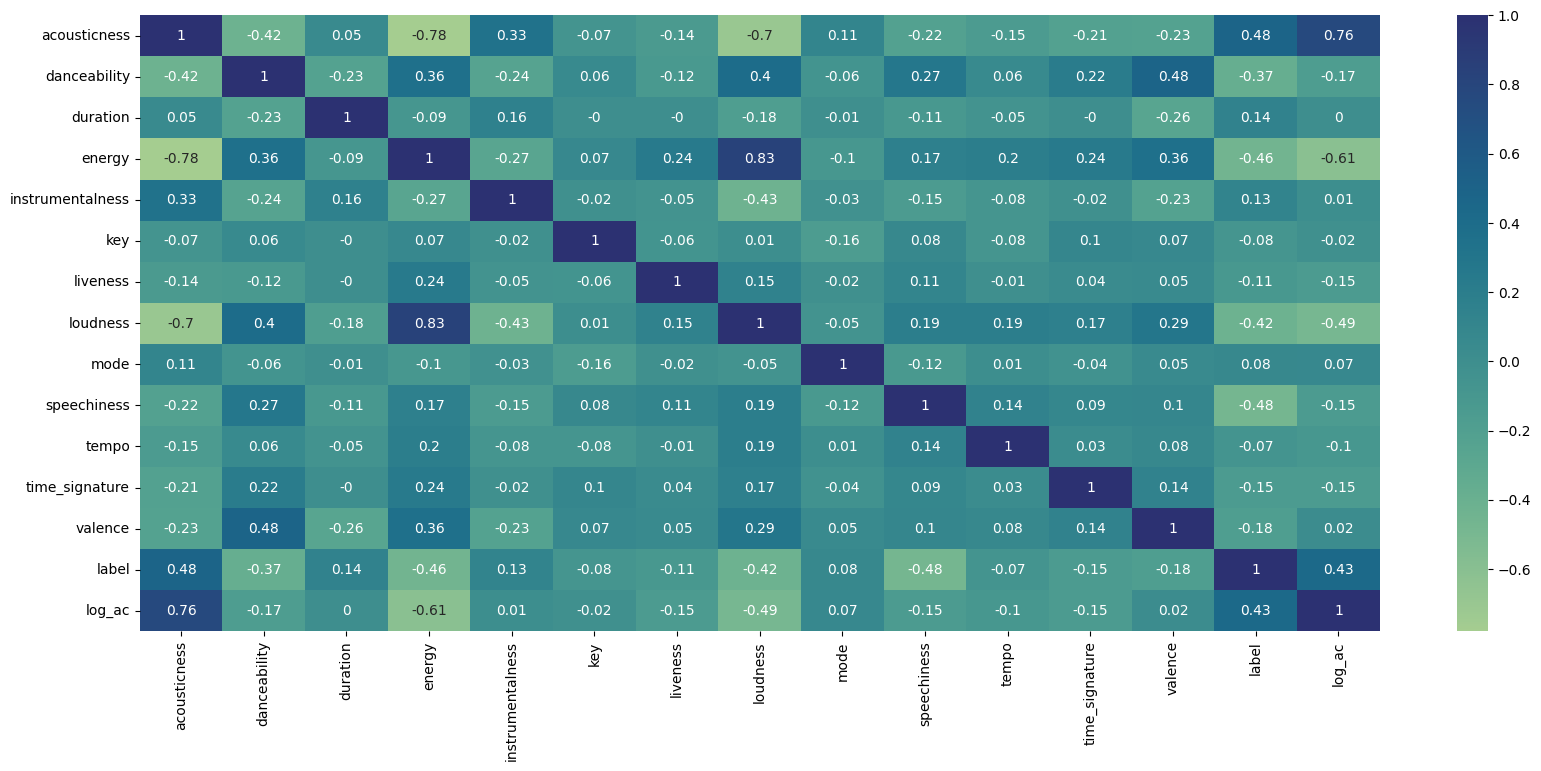

In [61]:
# Matriz de correlación, redondeo a 2 decimales
correlation_matrix = playlist.corr().round(2)
fig,axes = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes, cmap='crest');

- Podemos decir que con un valor de correlación arriba del 75%, esos dos features tienen cierta correlación.
- Podemos tomar `acousticness` con `energy` y `loudness` con `energy`.

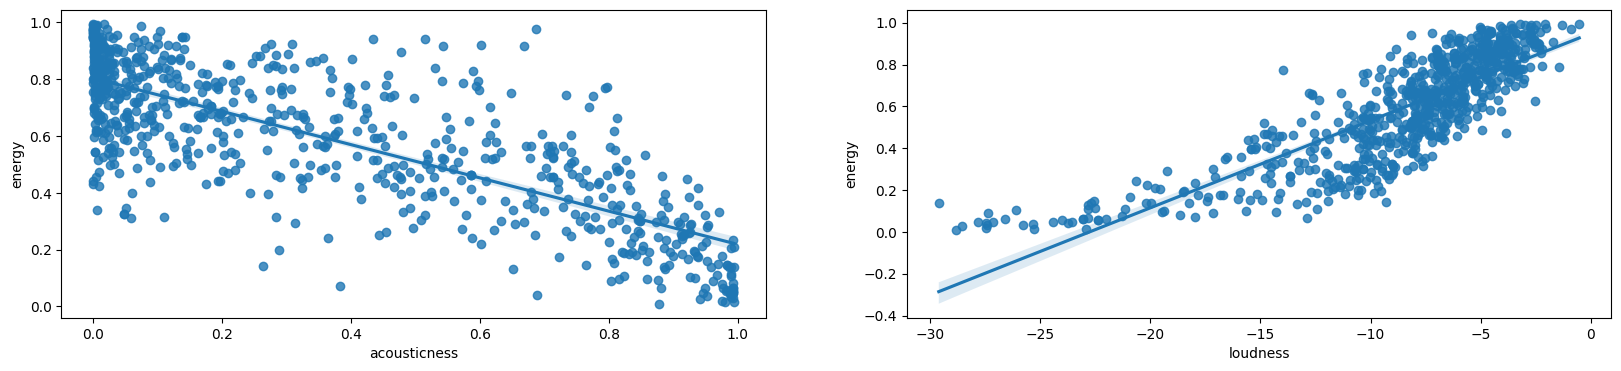

In [62]:
fig,axes = plt.subplots(1,2,figsize=(20,4))
sns.regplot(x="acousticness", y="energy", data=playlist, order=1,ax=axes[0])
sns.regplot(x="loudness", y="energy", data=playlist, order=1,ax=axes[1]);

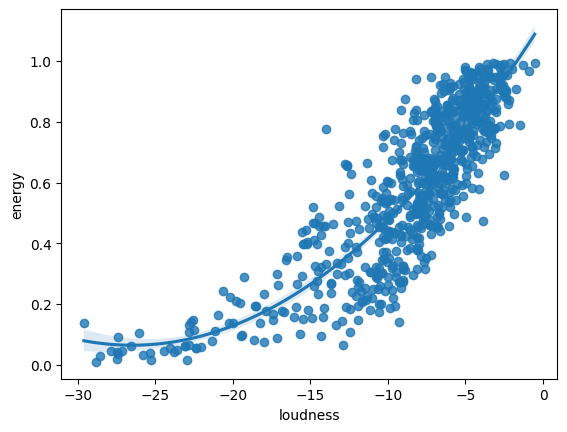

In [63]:
# Vemos si energy y loudness tienen una relación de orden mayor
sns.regplot(x="loudness", y="energy", data=playlist, order=2);

- Se adapta mejor a este modelo de orden 2.

- Ya en un grado menor, con la correlación en 70% podemos tomar las variables `loudness` y `acousticness`. Aunque el resultado no se ve prometedor.

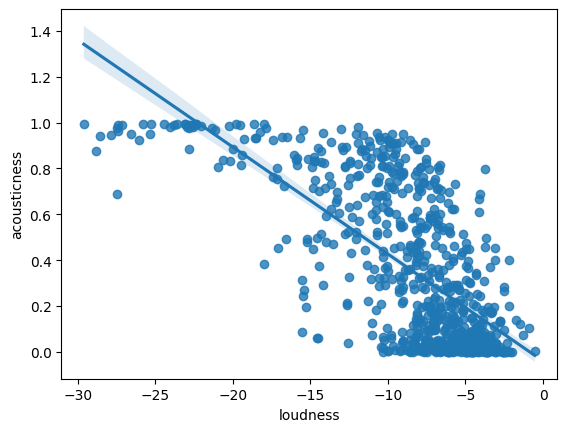

In [64]:
sns.regplot(x="loudness", y="acousticness", data=playlist, order=1);

<Axes: xlabel='danceability', ylabel='tempo'>

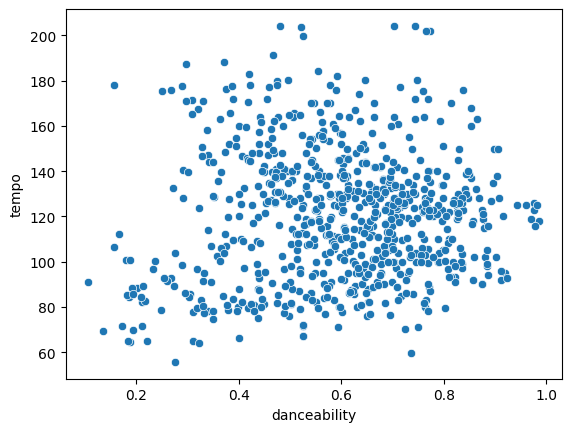

In [65]:
sns.scatterplot(x='danceability', y='tempo', data=playlist)

### Identificación de variables

In [66]:
# Variables de entrada
entrada = playlist.drop('label', axis=1)
salida = playlist.label

#### Boxplot

In [67]:
entre_0y1 = playlist[numericas].drop(['duration','loudness', 'tempo'], axis=1)
plt.figure(figsize=(20,8))
#sns.boxplot(entre_0y1);

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

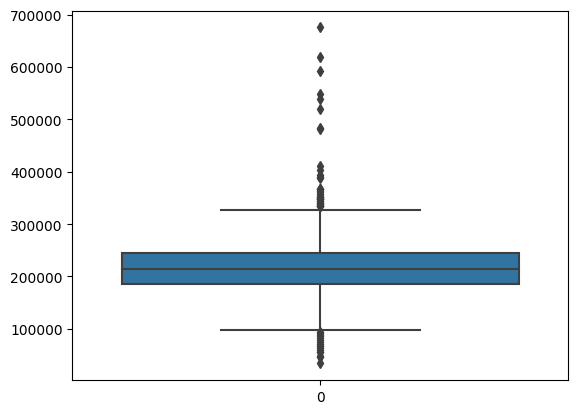

In [68]:
sns.boxplot(data=playlist['duration']);

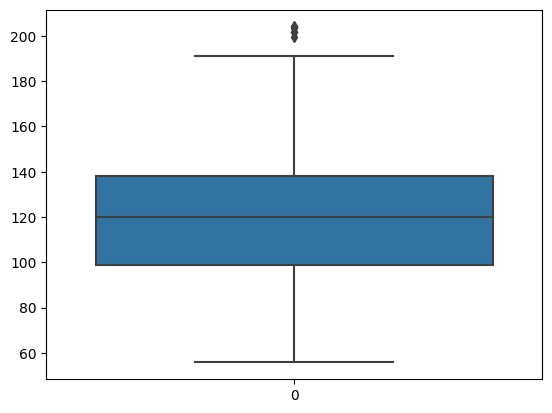

In [69]:
sns.boxplot(data=playlist['tempo']);

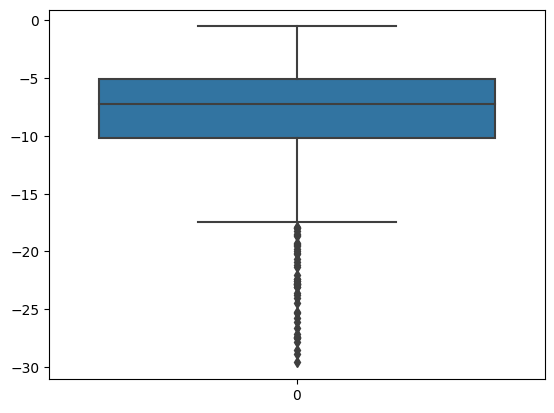

In [70]:
sns.boxplot(data=playlist['loudness']);

In [140]:
def outlier_diagnostic_plots(playlist, variable):
    fig,axes = plt.subplots(1,3,figsize=(20,4))

    # histograma
    sns.histplot(playlist[variable], bins=30,ax=axes[0], kde=True)
    axes[0].set_title('Histograma')
    
    # qqplot    
    stats.probplot(playlist[variable], dist="norm", plot=axes[1])
    axes[1].set_title('QQ')
    
    # boxplot    
    sns.boxplot(y=playlist[variable],ax=axes[2])
    axes[2].set_title('Box&Whiskers')

    fig.suptitle(variable, fontsize=16)

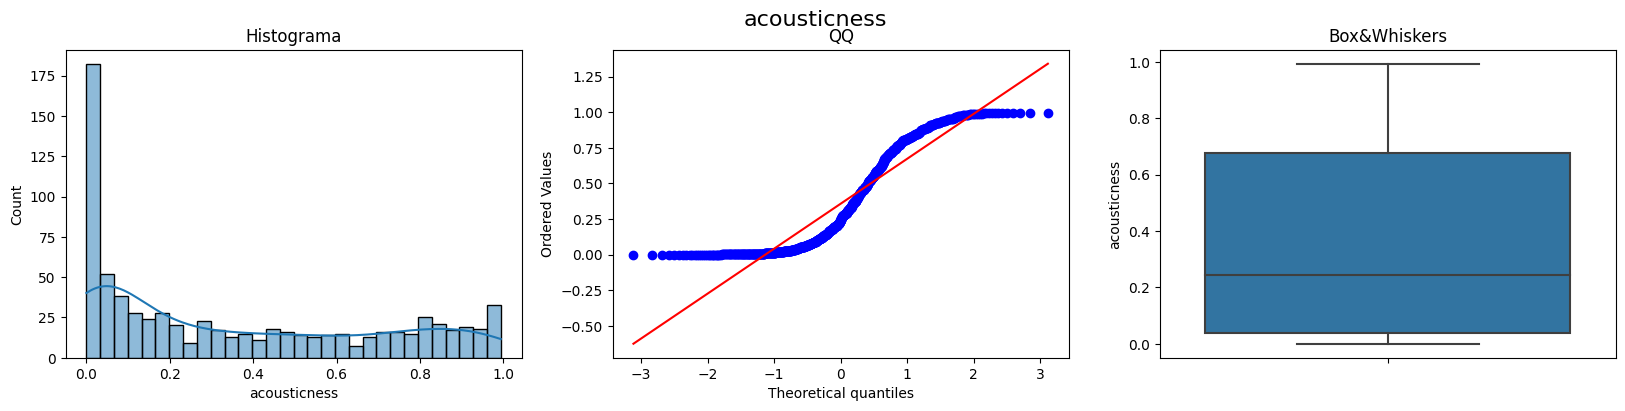

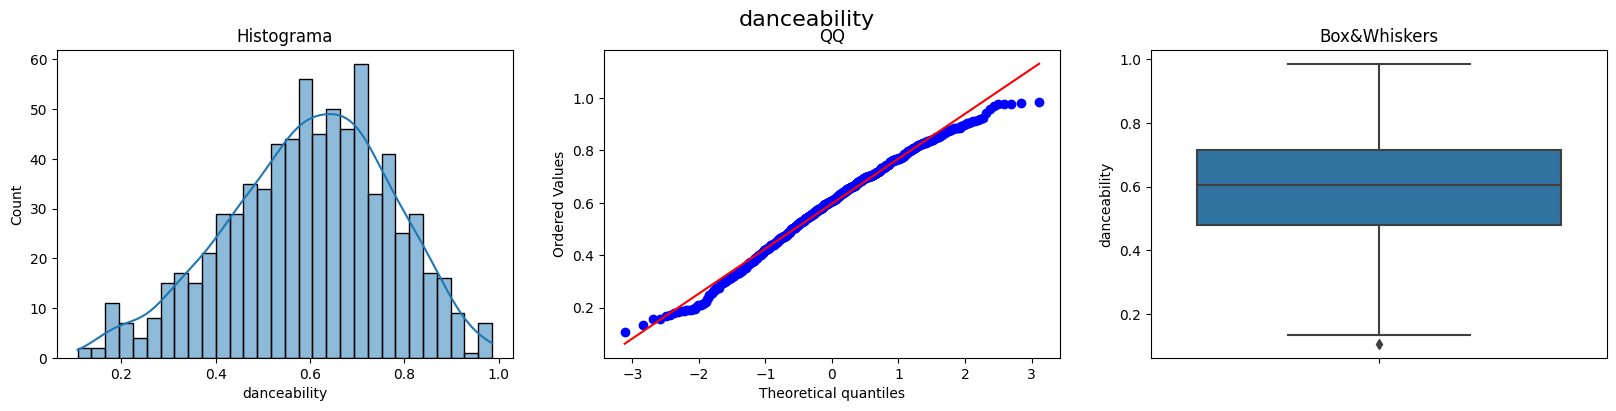

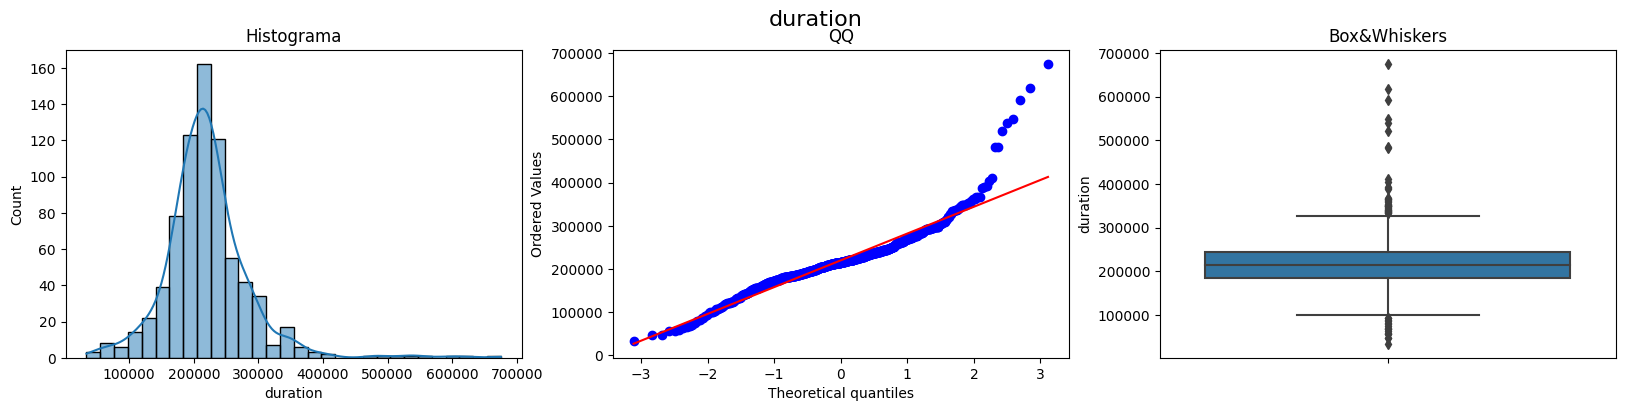

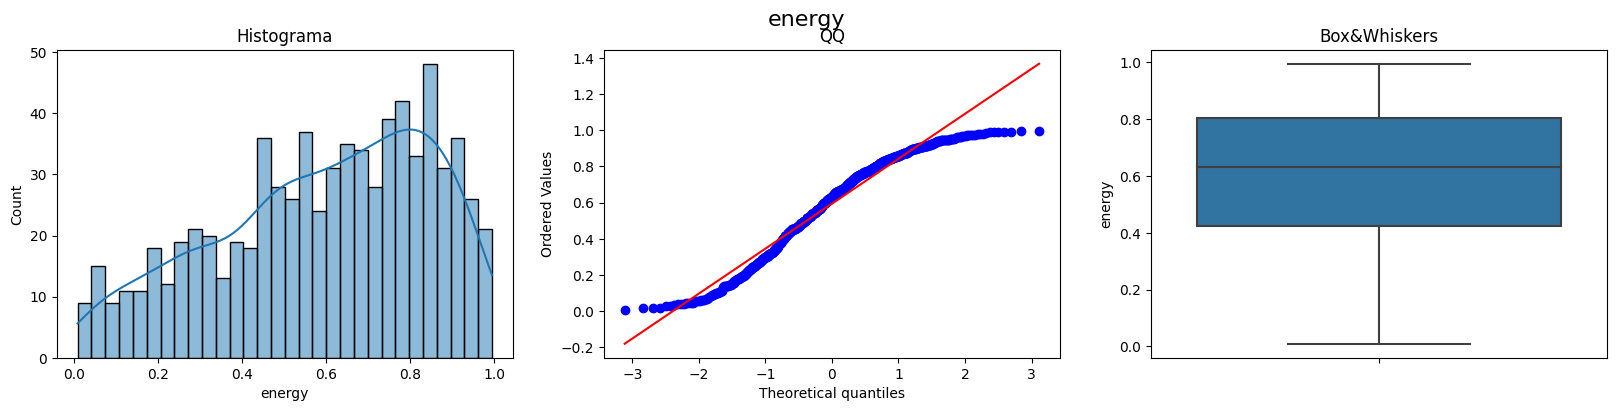

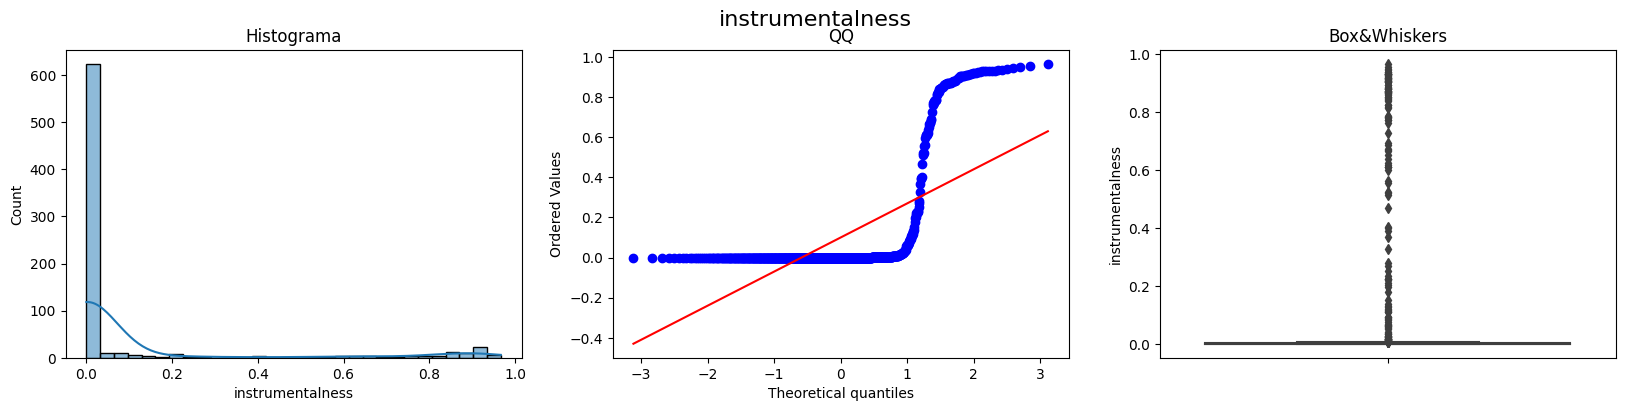

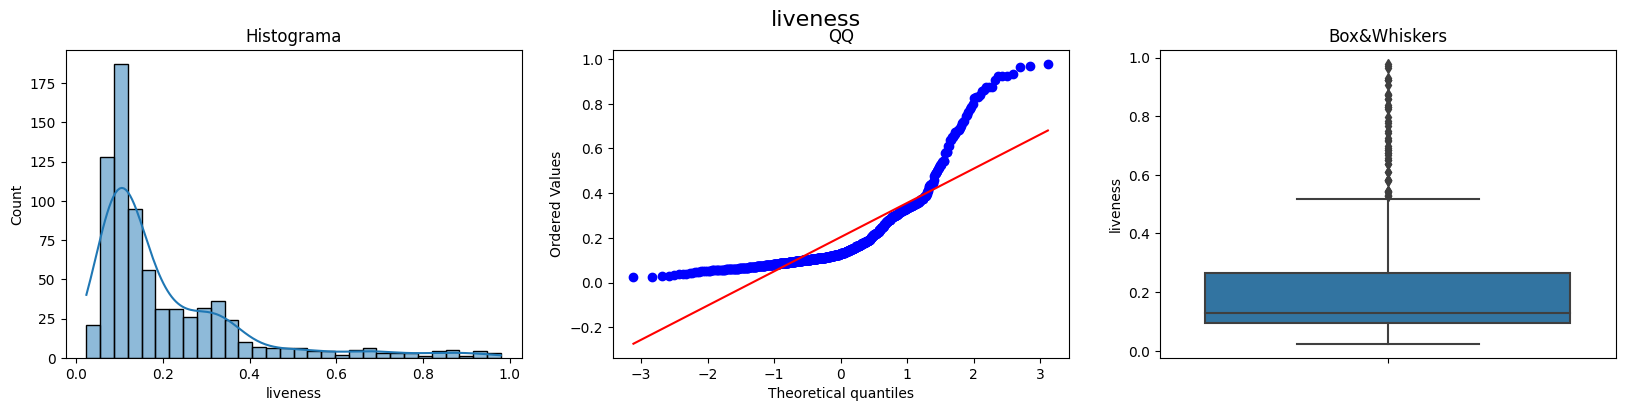

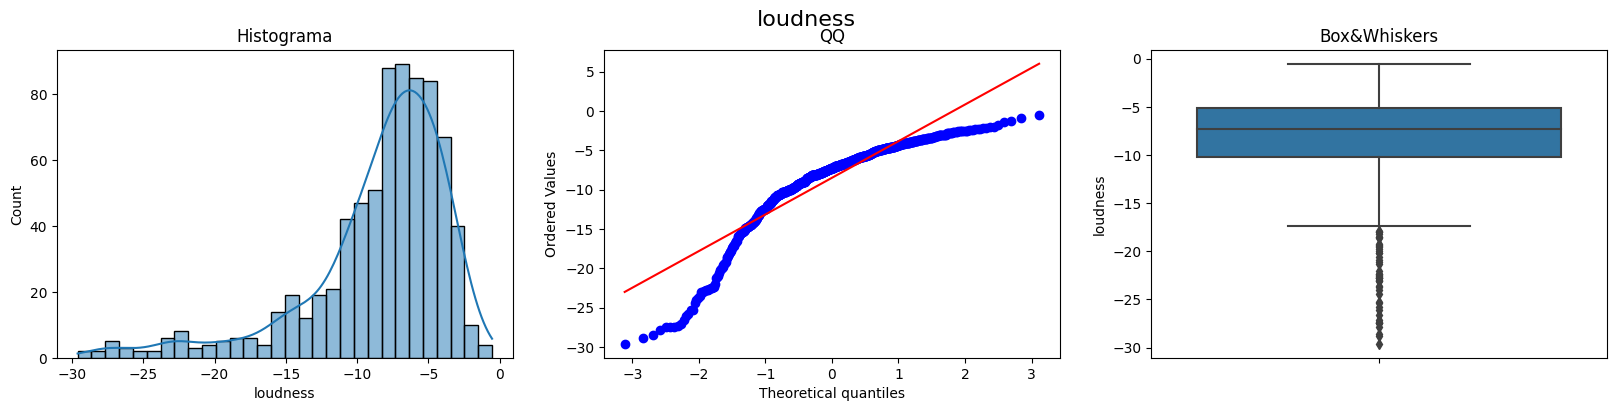

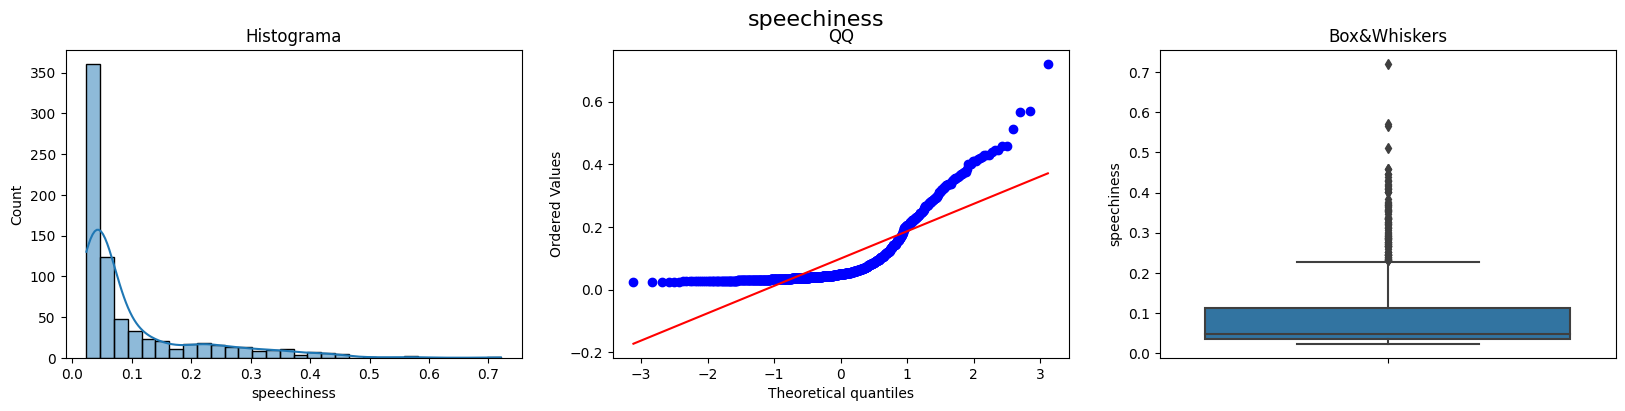

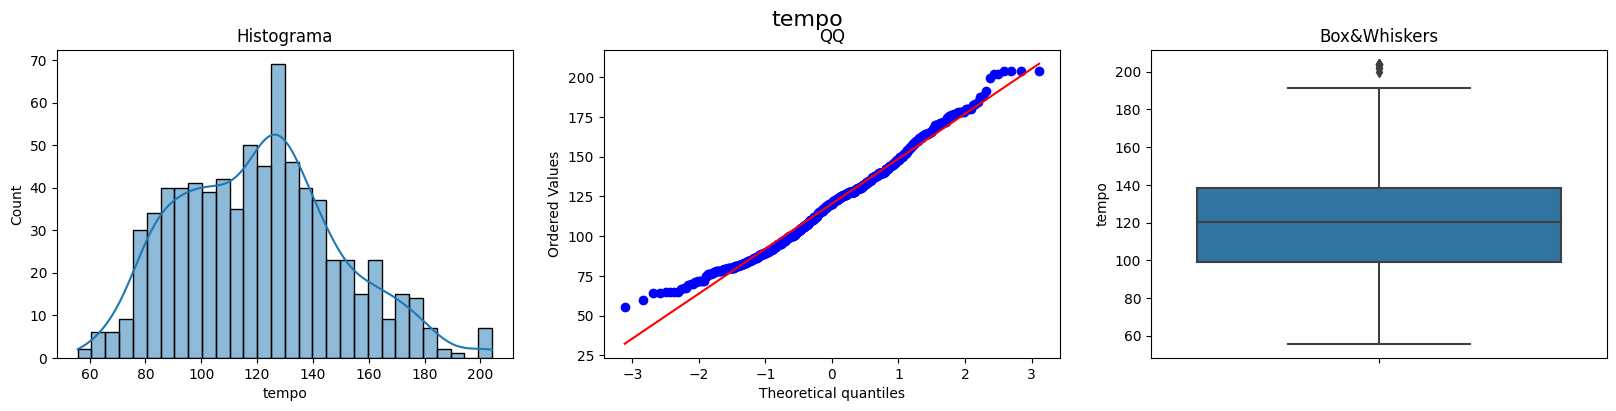

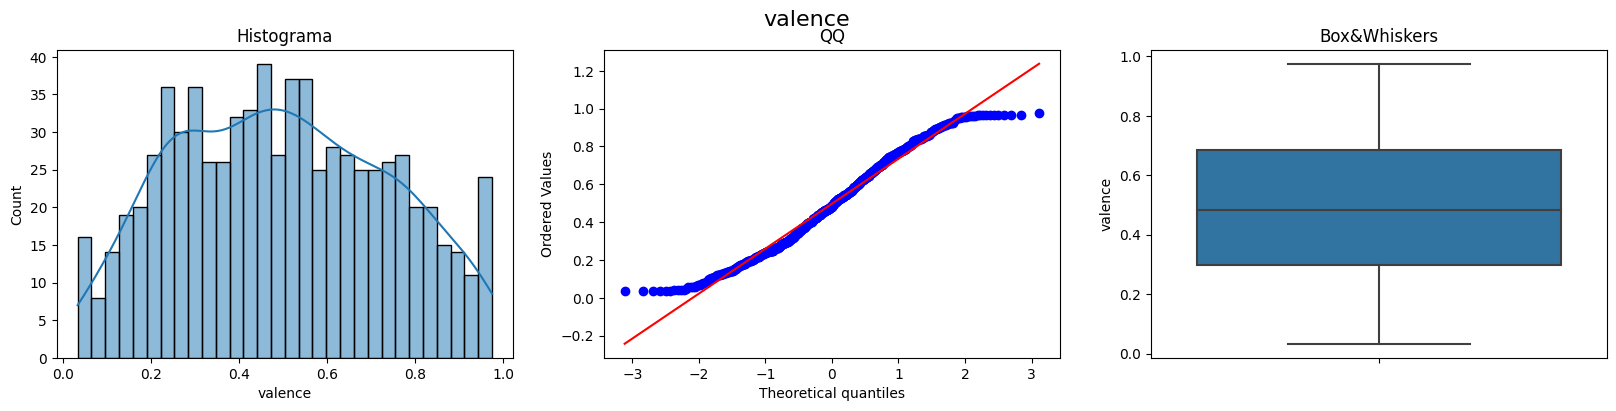

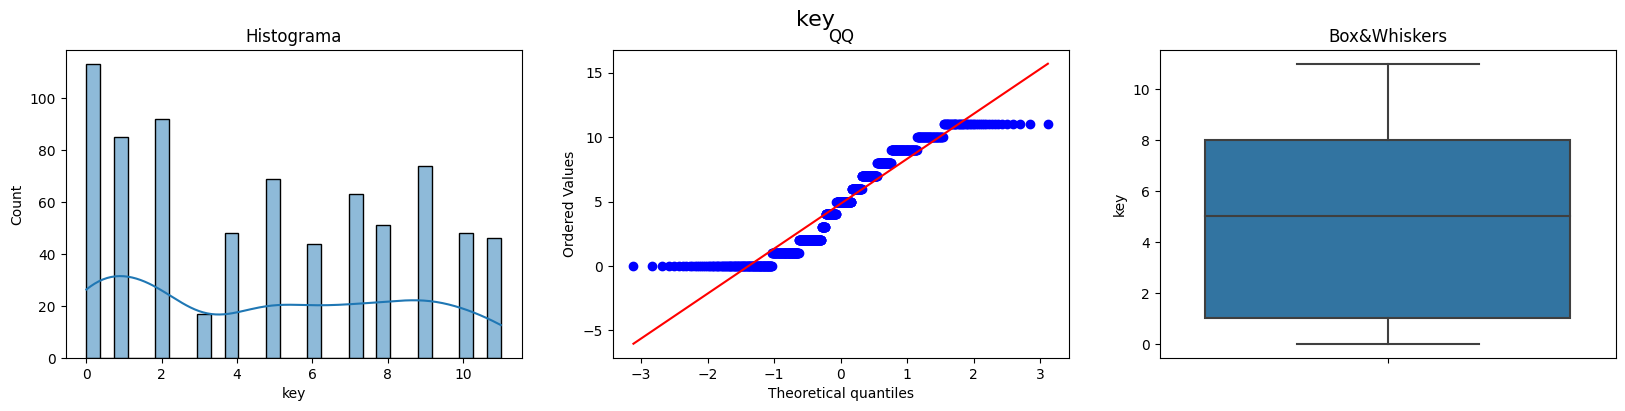

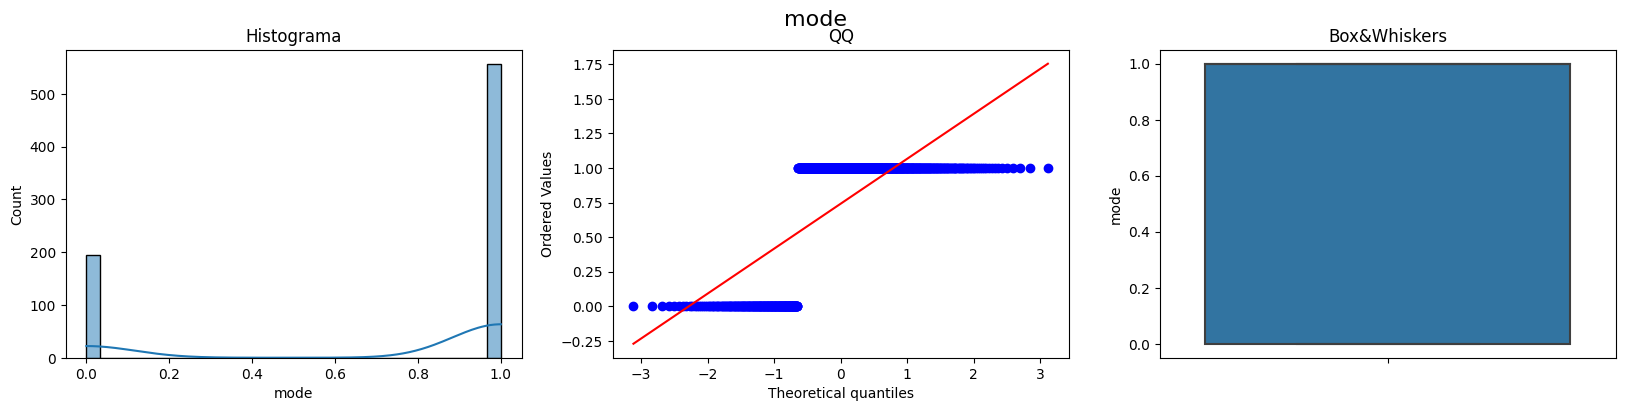

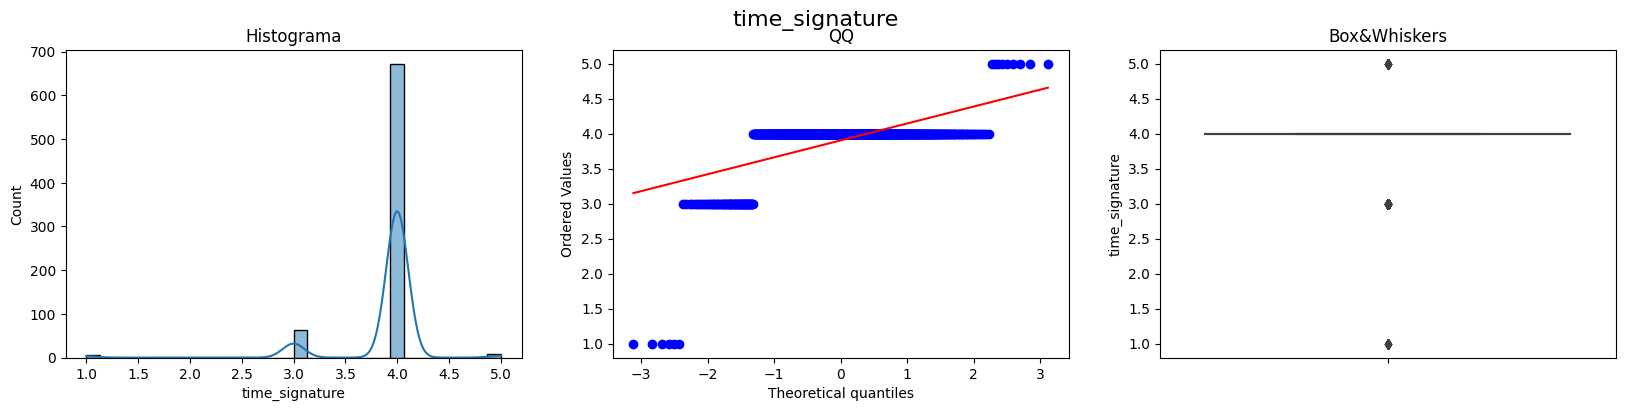

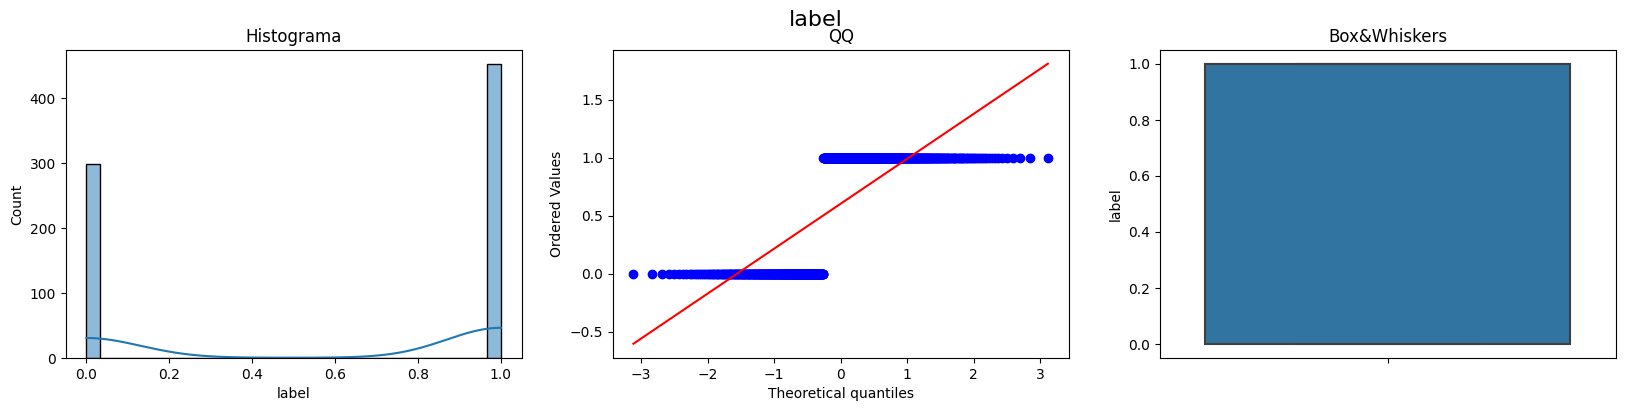

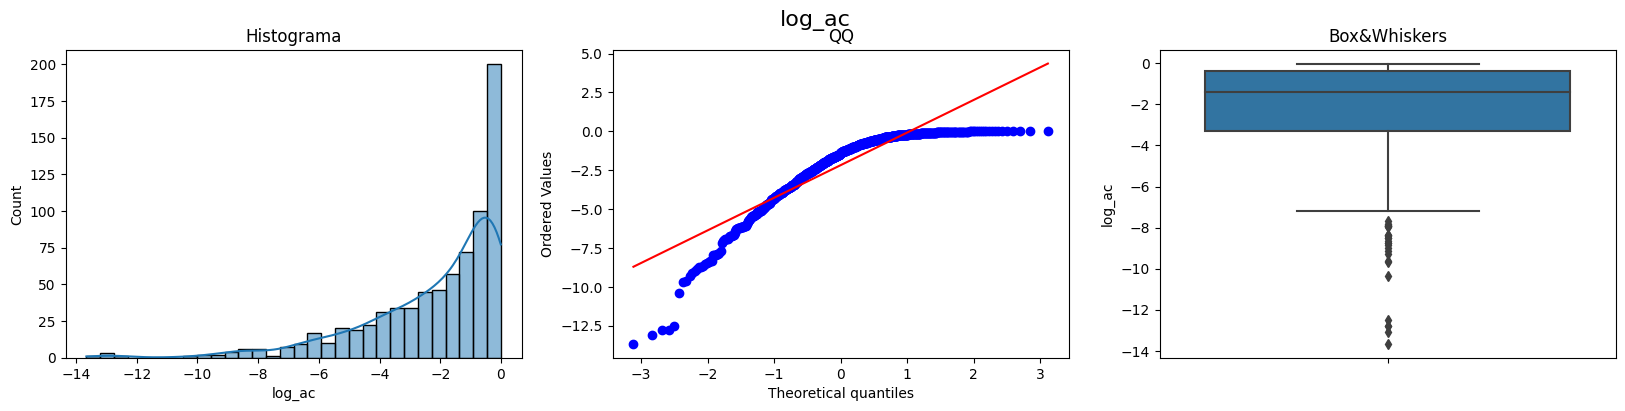

In [223]:
norm_col = [
            'acousticness',
            'danceability', 
            'duration', 
            'energy', 
            'instrumentalness',
            'liveness', 
            'loudness', 
            'speechiness', 
            'tempo', 
            'valence',
            'key',
            'mode',
            'time_signature',
            'label',
            'log_ac'
]

for col in norm_col:
    outlier_diagnostic_plots(playlist, col)

In [224]:
def find_skewed_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary
    
def transform_outliers(df, norm_col, threshold_capped=1.5, threshold_trimmed=1.8, use_manual_limits=False, 
                        upper_limit_trim=0, lower_limit_trim=0, upper_limit_cap=0, lower_limit_cap=0):
    # Trimming and capping outliers
    outliers_total = np.array(np.repeat(False,df.shape[0]))
    X_capped = df.copy()
    for col in norm_col:
        
        if use_manual_limits:
            upper_limit, lower_limit = upper_limit_trim, lower_limit_trim
        else:
            upper_limit, lower_limit = find_skewed_boundaries(df, col, threshold_trimmed)

        outliers = np.where(df[col] > upper_limit, True,
                            np.where(df[col] < lower_limit, True, False))                        
        outliers_total = np.logical_or(outliers_total, outliers)
        
        print(str(col) + " outliers = "+str(outliers.sum()))
        
        if use_manual_limits:
            upper_limit, lower_limit = upper_limit_cap, lower_limit_cap
        else:
            upper_limit, lower_limit = find_skewed_boundaries(df, col, threshold_capped)

        X_capped[col] = np.where(df[col] > upper_limit, upper_limit,
                            np.where(df[col] < lower_limit, lower_limit, X_capped[col]))

    print("Total outliers = "+str(outliers_total.sum()))
    X_trimmed = X_capped.loc[~(outliers_total)]

    return X_trimmed

acousticness outliers = 0
danceability outliers = 0
duration outliers = 34
energy outliers = 0
instrumentalness outliers = 157
liveness outliers = 44
loudness outliers = 41
speechiness outliers = 81
tempo outliers = 0
valence outliers = 0
key outliers = 0
mode outliers = 0
time_signature outliers = 79
label outliers = 0
log_ac outliers = 16
Total outliers = 335


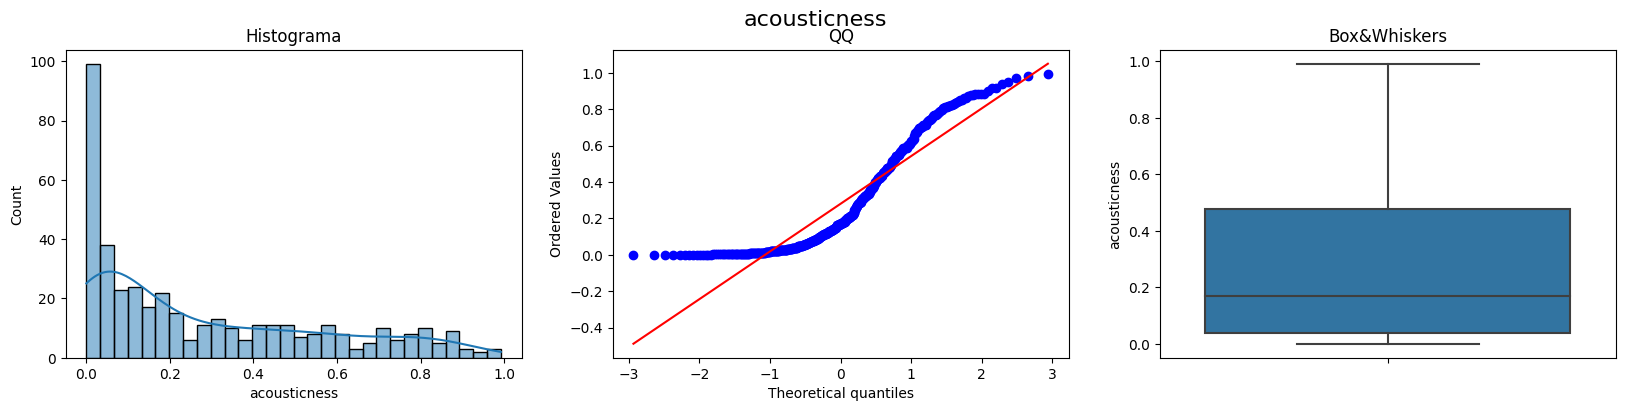

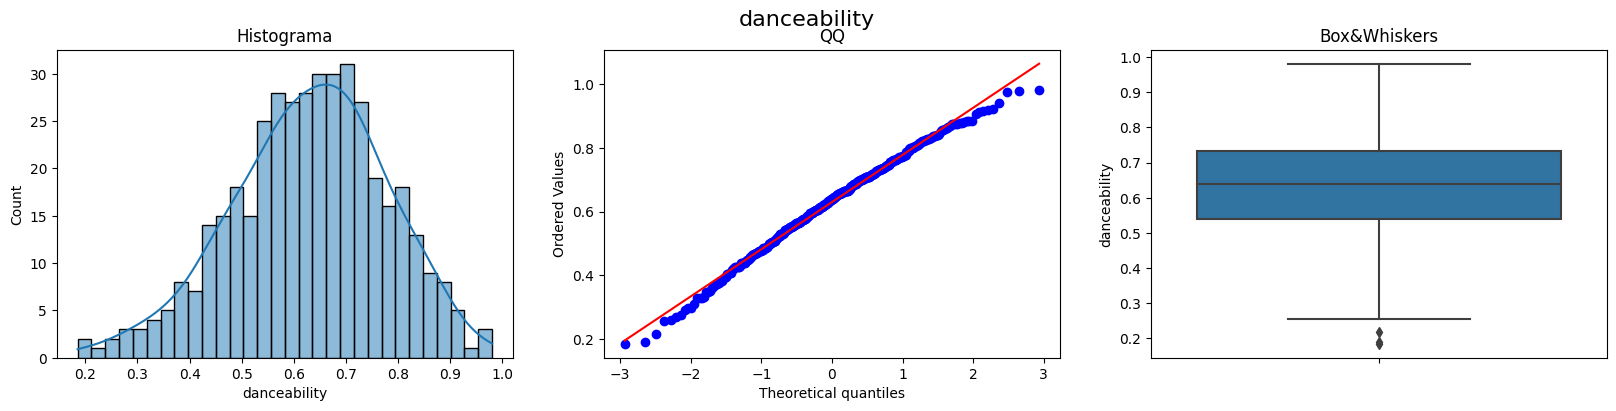

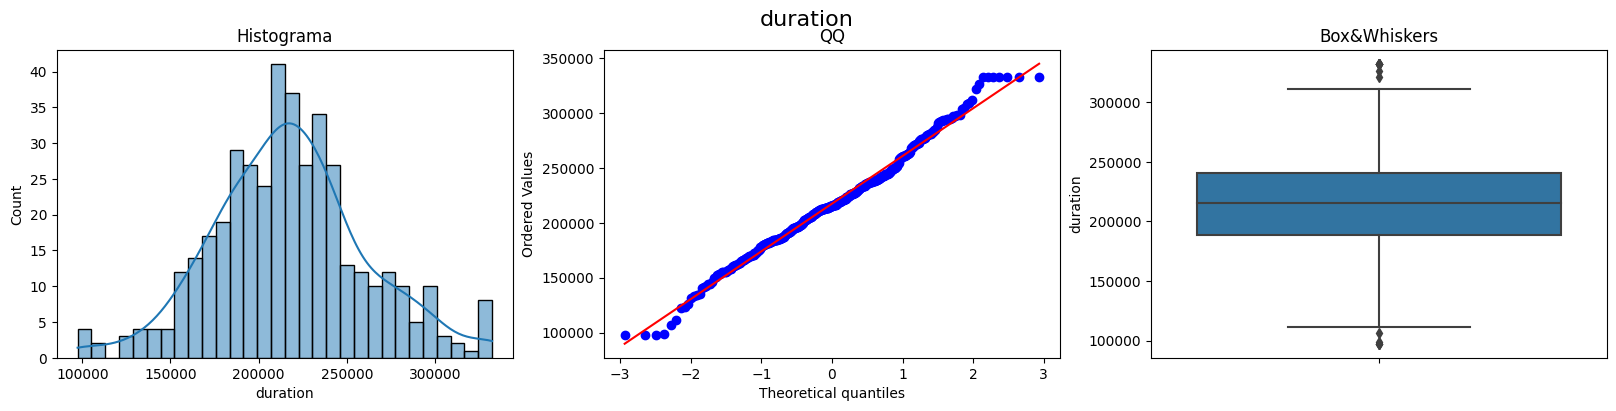

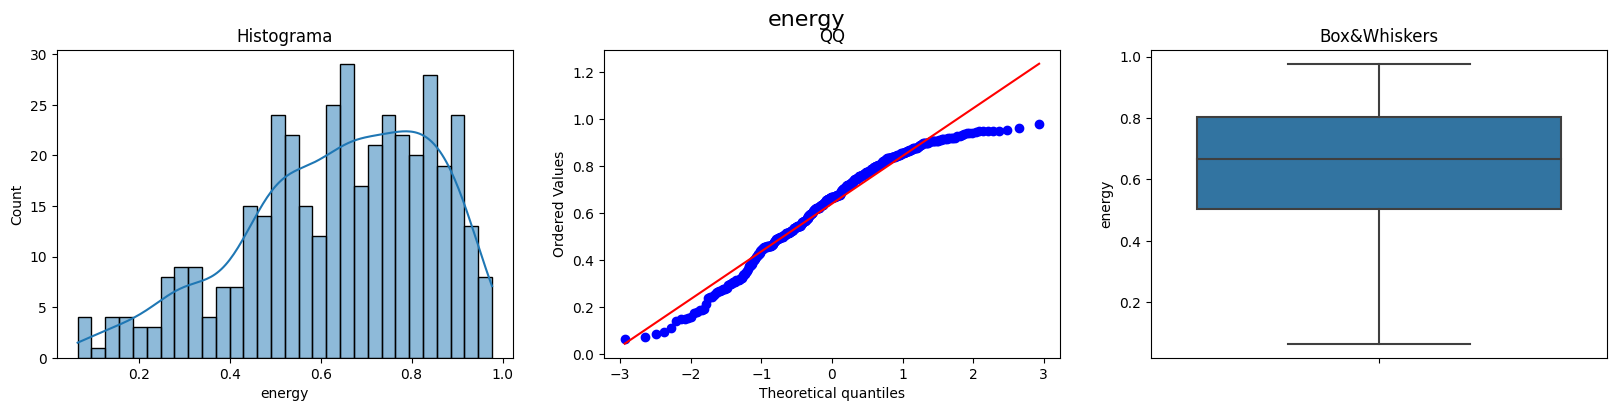

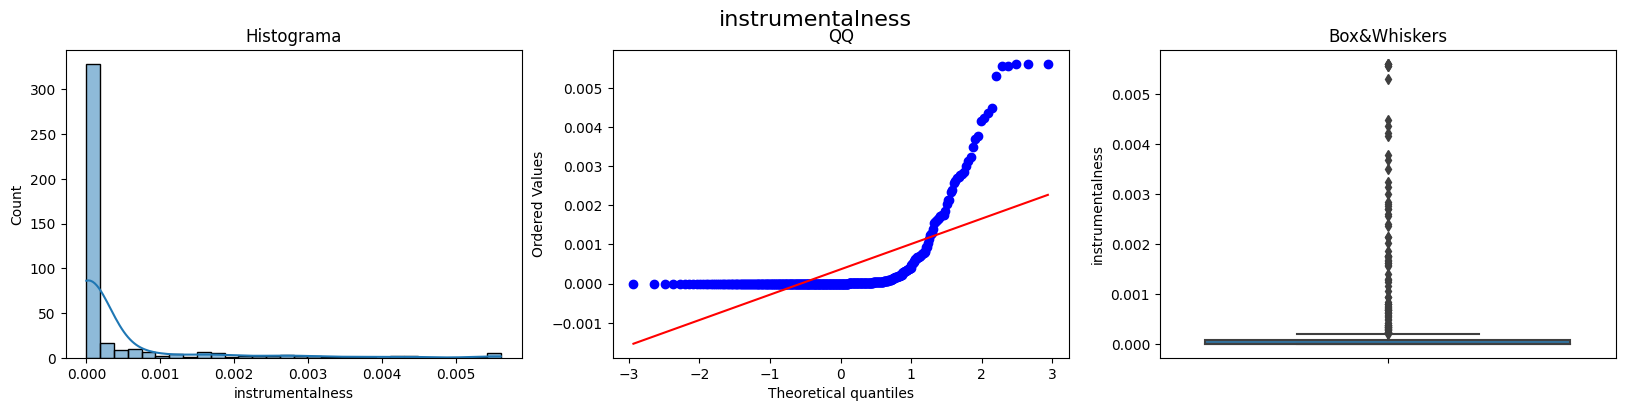

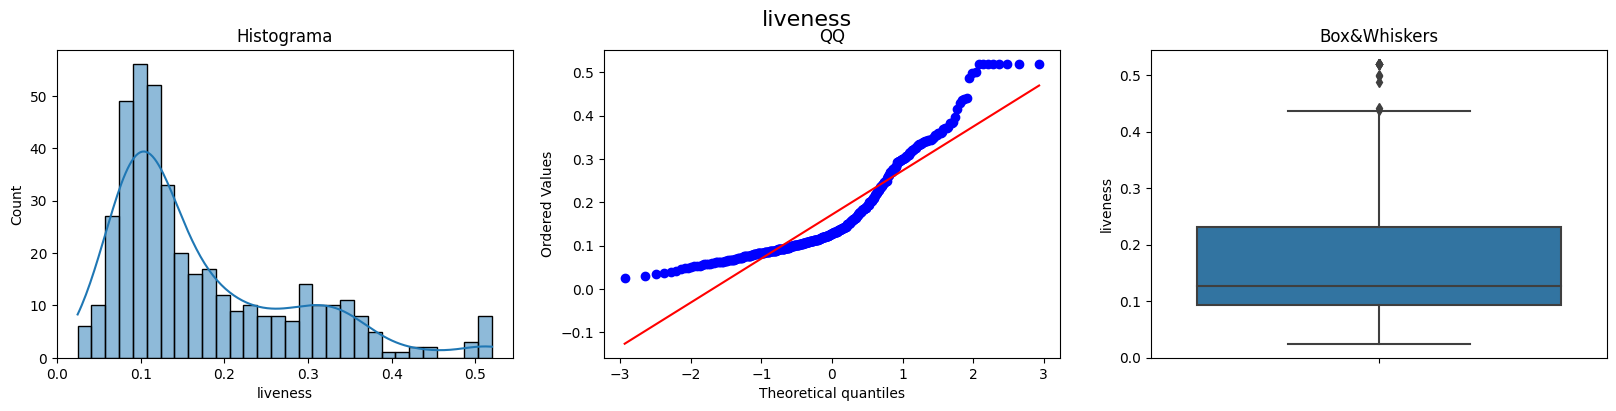

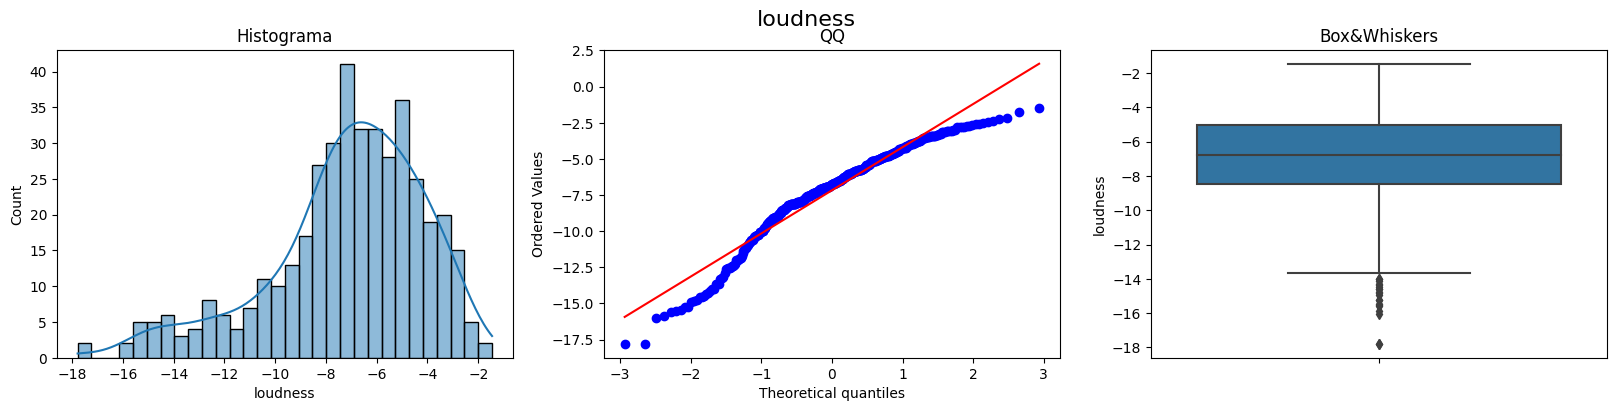

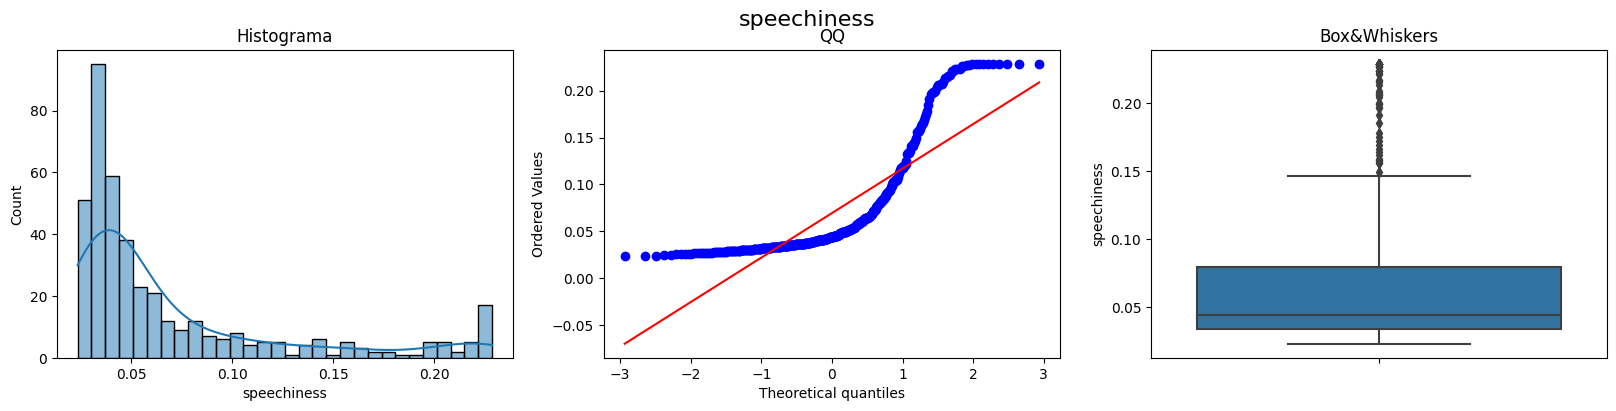

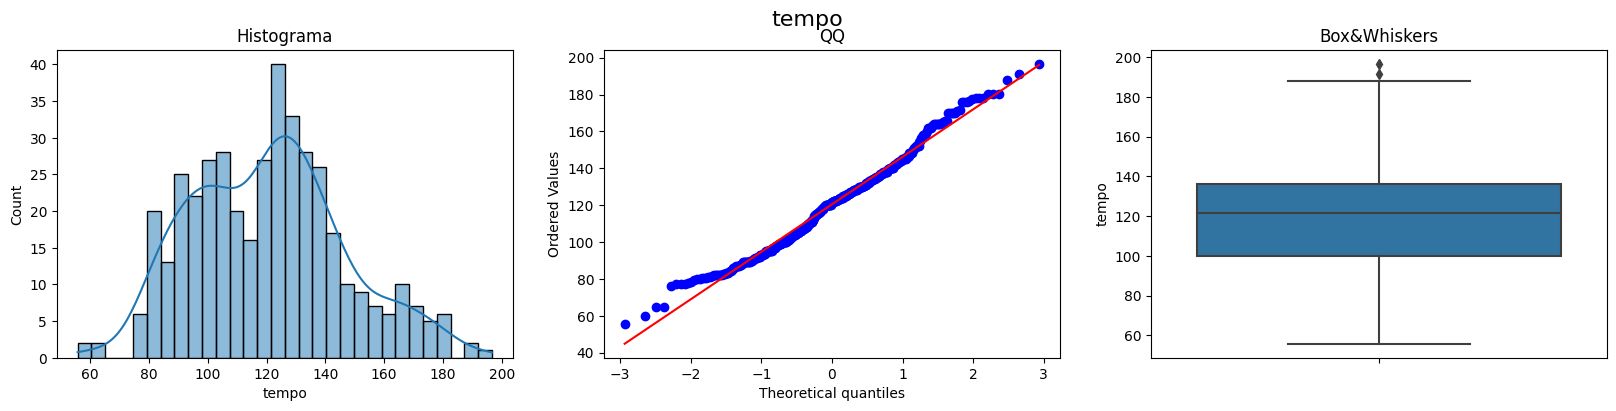

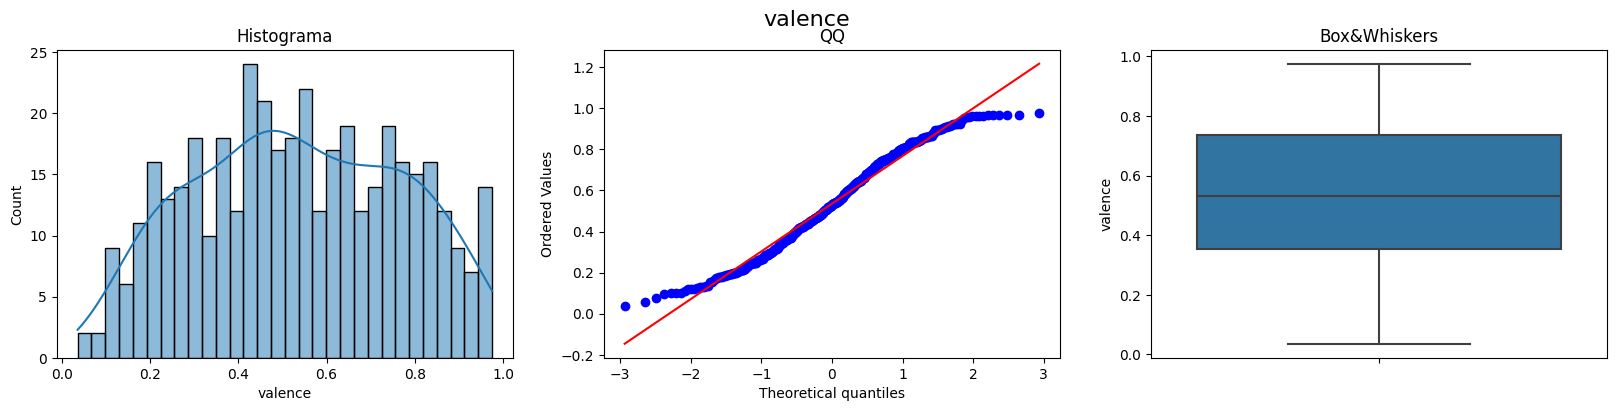

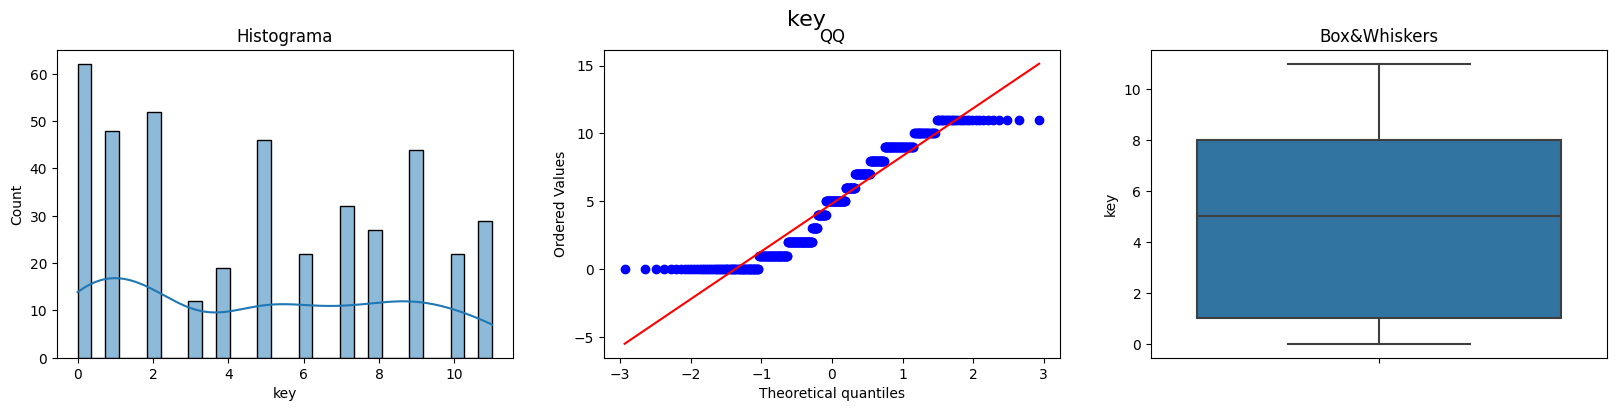

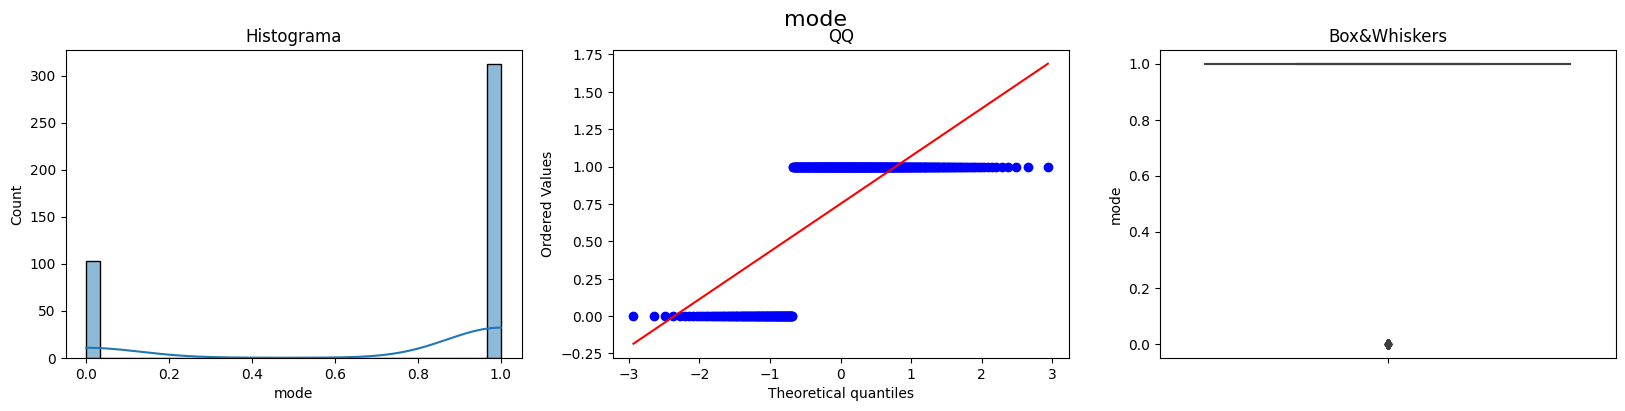

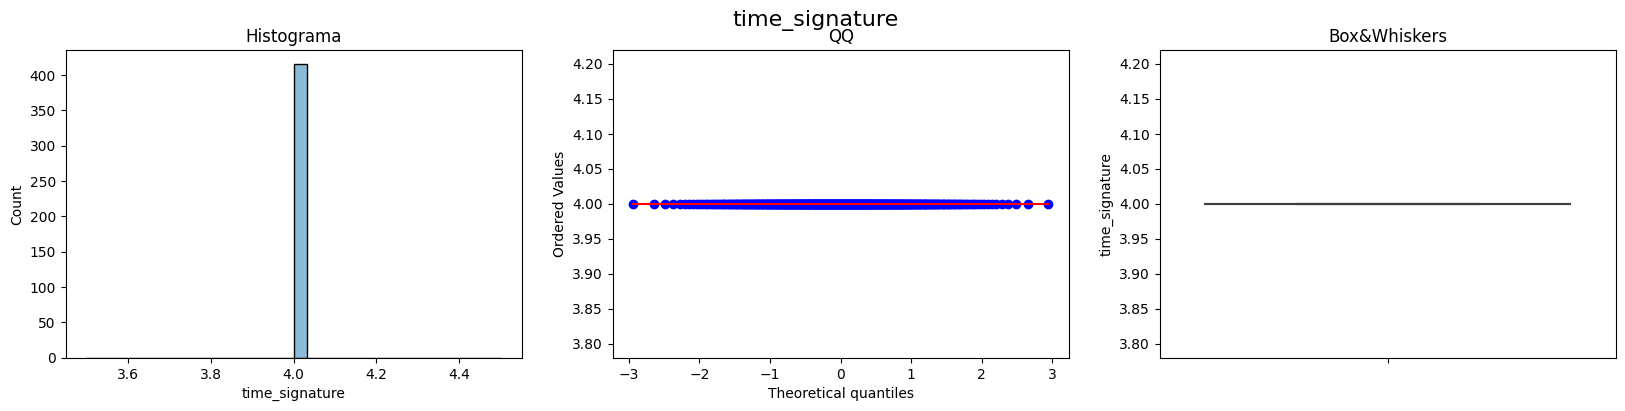

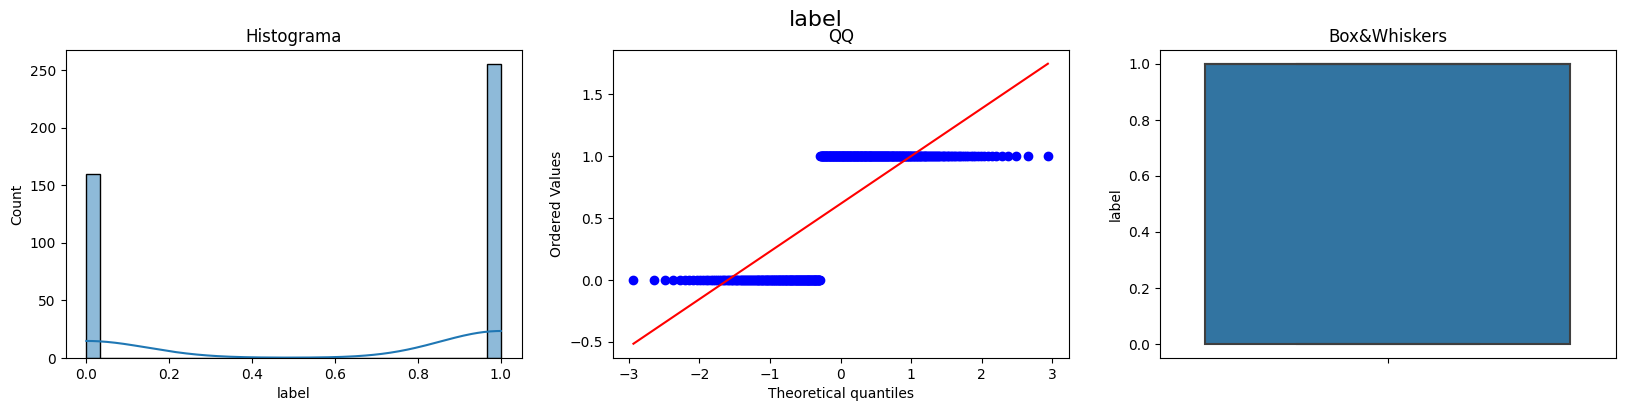

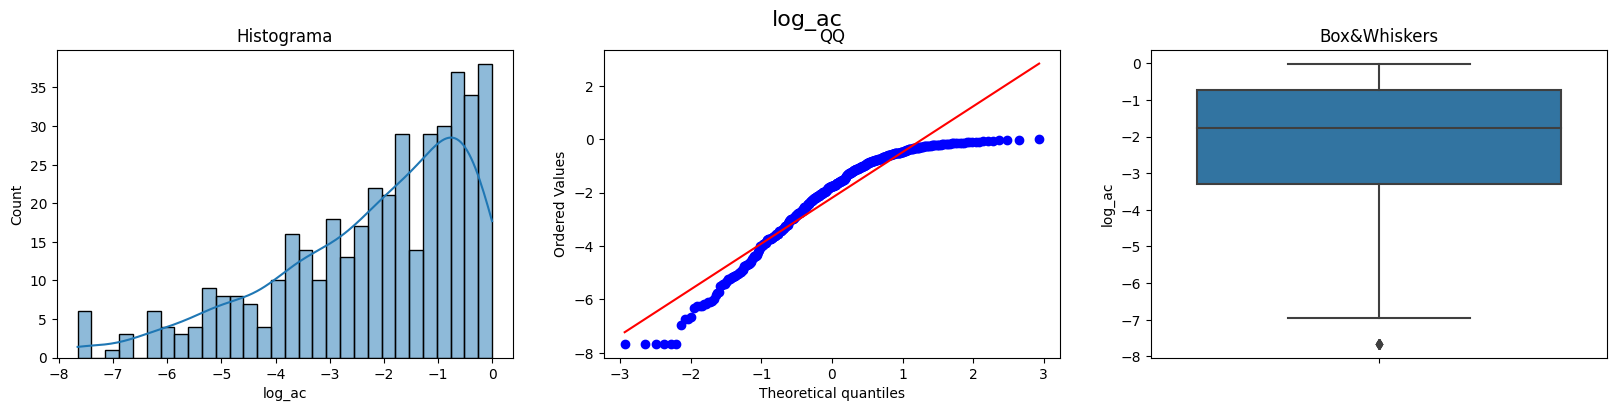

In [225]:
X_trimmed = transform_outliers(playlist, norm_col)

for col in norm_col:
    outlier_diagnostic_plots(X_trimmed, col)
    
X = X_trimmed

2.6 Magnitud de las variables de entrada
- #### Algoritmos afectados
- Regresión lineal y logística.
-  Redes neuronales.
-  Support Vector Machines.
- KNN.
- K-means.
-  Principal Component Analysis (PCA).
- #### No afectados (por ejemplo, los basados en árboles)
- Árboles de clasificación y regresión.
- Random Forest
- Gradient Boosted Trees.

## Pruebas de modelos

In [226]:
playlist.columns

Index(['acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'label', 'log_ac'],
      dtype='object')

In [72]:
# # Diferenciamos en X y en y las variables
# X = playlist.drop(columns='label')
# y = playlist.label

In [227]:
y_train = X['label']

X = X.drop(['label'], axis=1)
y = y_train    
print(len(y_train))
print(len(X))
print(len(y))
print(len(X))

415
415
415
415


In [228]:
# Primero realizamos el split
# Particionamos en train y test porque tenemos pocos datos
train_ratio = 0.80
# validation_ratio = 0.20
test_ratio = 1 - train_ratio

# En SKLearn no hay una función para hacer todo en un paso así que lo hacemos en 2.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=(validation_ratio/(validation_ratio+test_ratio))) 

print("Train shape: ", X_train.shape,y_train.shape)
# print("Val: ",X_val.shape,y_val.shape)
print("Test shape:", X_test.shape,y_test.shape)

Train shape:  (332, 14) (332,)
Test shape: (83, 14) (83,)


In [229]:
# Vamos a revisar qué tiene cada split
print(f"Contamos los labels de train:\n{y_train.value_counts()/len(y_train)}")
print(f"Contamos los labels de test: \n{y_test.value_counts()/len(y_test)}")

Contamos los labels de train:
label
1.0    0.629518
0.0    0.370482
Name: count, dtype: float64
Contamos los labels de test: 
label
1.0    0.554217
0.0    0.445783
Name: count, dtype: float64


### Regresión Logística

In [230]:
# Vamos a usar regresión logística porque se quiere predecir si es una clase 0 o 1
log_reg = LogisticRegression() # usamos un modelo por default

In [231]:
# Vamos a usar todos los features numéricos para entrenar
X_train_num = X_train[numericas]
X_test_num = X_test[numericas]

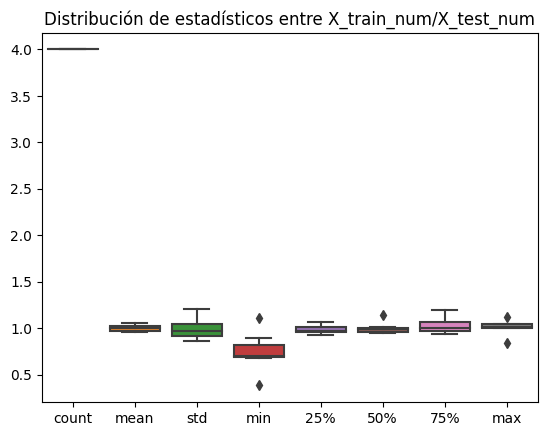

In [232]:
to_plot = X_train_num.describe().T / X_test_num.describe().T
sns.boxplot(data=to_plot)
plt.title("Distribución de estadísticos entre X_train_num/X_test_num")
plt.show()

In [233]:
# Entrenamos el modelo con este dataset
log_reg.fit(X_train_num, y_train)

LogisticRegression()

In [234]:
# Predecimos los valores
y_hat = log_reg.predict(X_test_num)

In [235]:
# Vamos a ver cómo salió la clasificación
cm = confusion_matrix(y_test, y_hat)
print(cm)

[[ 2 35]
 [ 0 46]]


In [236]:
cr = classification_report(y_test, y_hat)
print(cr)

              precision    recall  f1-score   support

         0.0       1.00      0.05      0.10        37
         1.0       0.57      1.00      0.72        46

    accuracy                           0.58        83
   macro avg       0.78      0.53      0.41        83
weighted avg       0.76      0.58      0.45        83



In [237]:
# Realizamos un scalado de los datos para mejorar las distribuciones numéricas
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.fit(X_test_num)

In [238]:
# Realizamos la misma regresión logística pero con los datos escalados
log_reg_scaled = LogisticRegression()
log_reg_scaled.fit(X_train_num_scaled, y_train)

LogisticRegression()

In [239]:
X_test_num_scaled = scaler.transform(X_test_num)

In [240]:
# Predecimos los valores
y_hat_scaled = log_reg_scaled.predict(X_test_num_scaled)

cm = confusion_matrix(y_test, y_hat_scaled)
print("La matriz de confusión: \n", cm)

La matriz de confusión: 
 [[19 18]
 [ 9 37]]


In [241]:
cr = classification_report(y_test, y_hat_scaled)
print("Reporte de clasificación: \n", cr)

Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.68      0.51      0.58        37
         1.0       0.67      0.80      0.73        46

    accuracy                           0.67        83
   macro avg       0.68      0.66      0.66        83
weighted avg       0.68      0.67      0.67        83



- Predice mejor los labels escalando los datos

In [242]:
# Vamos a analizar usando también los features categóricos
X_train[categoricas].head()

,key,mode,time_signature
446,2.0,1.0,4.0
653,0.0,0.0,4.0
352,1.0,1.0,4.0
285,0.0,0.0,4.0
11,2.0,1.0,4.0


In [243]:
X_train.columns

Index(['acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'log_ac'],
      dtype='object')

In [244]:
# Si pasamos todos los features sin escalar los numéricos al modelo de regresión logística
log_reg_raw = LogisticRegression()
log_reg_raw.fit(X_train, y_train)

LogisticRegression()

In [245]:
# Predecimos los valores
y_hat_raw = log_reg_raw.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat_raw)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat_raw)
print("Reporte de clasificación: \n", cr)

La matriz de confusión: 
 [[22 15]
 [ 9 37]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.71      0.59      0.65        37
         1.0       0.71      0.80      0.76        46

    accuracy                           0.71        83
   macro avg       0.71      0.70      0.70        83
weighted avg       0.71      0.71      0.71        83



In [246]:
# Vamos a usar los datos numéricos escalados y adjuntamos los features categóricos
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=numericas)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=numericas)

In [247]:
# X_train_raw_scaled = X_train_num_scaled.join(X_train[categoricas], how='right') --> no funciona con este join ya que se generan NaN

In [248]:
# Adjuntamos ambos datos; la mejor forma fue ir a numpy y luego concatenar ahi
columnas = numericas+categoricas
X_train_raw_scaled = pd.DataFrame(np.concatenate((X_train_num_scaled.values, X_train[categoricas].values), axis=1), columns=columnas)

In [249]:
# Hacemos lo mismo con el dataset de test
X_test_raw_scaled = pd.DataFrame(np.concatenate((X_test_num_scaled.values, X_test[categoricas].values), axis=1), columns=columnas)

In [250]:
# Si pasamos este dataframe al modelo de regresión logística
log_reg_raw_scaled = LogisticRegression()
log_reg_raw_scaled.fit(X_train_raw_scaled, y_train)

# Predecimos los valores
y_hat_raw_scaled = log_reg_raw_scaled.predict(X_test_raw_scaled)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat_raw_scaled)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat_raw_scaled)
print("Reporte de clasificación: \n", cr)

La matriz de confusión: 
 [[21 16]
 [ 9 37]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.70      0.57      0.63        37
         1.0       0.70      0.80      0.75        46

    accuracy                           0.70        83
   macro avg       0.70      0.69      0.69        83
weighted avg       0.70      0.70      0.69        83



- Este modelo tiene un buen valor de score, pero sigue siendo un poco mejor solamente usar los valores numericos escalados para reg. logística.

### Analizamos este modelo de regresión logística con las variables numéricas transformadas

In [251]:
# Definimos las variables que vamos a transformar
bc_tranformed = ['danceability', 'duration', 'energy', 'liveness', 'speechiness', 'tempo']
yj_tranformed = ['danceability', 'duration', 'energy', 'liveness', 'speechiness', 'tempo','loudness']

In [252]:
X_train_t = X_train[bc_tranformed]
X_train_t.shape

(332, 6)

In [253]:
X_test_t = X_test[bc_tranformed]

In [254]:
# Realizamos la transformación
bc = PowerTransformer(method='box-cox')
X_train_t = bc.fit_transform(X_train_t)

In [255]:
X_test_t = bc.transform(X_test_t)

In [256]:
X_train_t = pd.DataFrame(X_train_t, columns=bc_tranformed)
X_test_t = pd.DataFrame(X_test_t, columns=bc_tranformed)

In [257]:
# Modelamos con este dataset
log_reg_t = LogisticRegression()
log_reg_t.fit(X_train_t, y_train)

LogisticRegression()

In [258]:
# Predecimos los valores
y_hat_t = log_reg_t.predict(X_test_t)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat_t)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat_t)
print("Reporte de clasificación: \n", cr)

La matriz de confusión: 
 [[21 16]
 [ 8 38]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.72      0.57      0.64        37
         1.0       0.70      0.83      0.76        46

    accuracy                           0.71        83
   macro avg       0.71      0.70      0.70        83
weighted avg       0.71      0.71      0.70        83



- Usando solamente los features que pueden transformarse con Box-Cox, el score queda muy similar a cuando se usa el escalado numerico y las categóricas.

In [259]:
# Probamos ahora usando Yeo-Johnson y sumando loudness
X_train_t = X_train[yj_tranformed]
X_test_t = X_test[yj_tranformed]

yj = PowerTransformer(method='yeo-johnson')
X_train_t = yj.fit_transform(X_train_t)
X_test_t = yj.transform(X_test_t)

X_train_t = pd.DataFrame(X_train_t, columns=yj_tranformed)
X_test_t = pd.DataFrame(X_test_t, columns=yj_tranformed)

log_reg_t = LogisticRegression()
log_reg_t.fit(X_train_t, y_train)

# Predecimos los valores
y_hat_t = log_reg_t.predict(X_test_t)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat_t)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat_t)
print("Reporte de clasificación: \n", cr)

La matriz de confusión: 
 [[21 16]
 [ 9 37]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.70      0.57      0.63        37
         1.0       0.70      0.80      0.75        46

    accuracy                           0.70        83
   macro avg       0.70      0.69      0.69        83
weighted avg       0.70      0.70      0.69        83



- Mejoro un poco al agregar loudness y transformar todo con Yeo-Johnson.

## Aplicamos árbol de clasificación

In [260]:
from sklearn.tree import DecisionTreeClassifier

# Creamos el arbol
classification = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

In [261]:
# Clasificamos primero con los sets sin modificaciones
classification.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [262]:
# Predecimos los valores
y_hat = classification.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

La matriz de confusión: 
 [[22 15]
 [10 36]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.69      0.59      0.64        37
         1.0       0.71      0.78      0.74        46

    accuracy                           0.70        83
   macro avg       0.70      0.69      0.69        83
weighted avg       0.70      0.70      0.70        83



- Con el árbol de clasificación sin hacer ningún tipo de modificación en los datos, tenemos el mejor score de todos los realizados con regresión logística.

## Vemos random forests

In [263]:
rand_for = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
rand_for.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [264]:
# Predecimos los valores
y_hat = rand_for.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

La matriz de confusión: 
 [[24 13]
 [ 7 39]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.77      0.65      0.71        37
         1.0       0.75      0.85      0.80        46

    accuracy                           0.76        83
   macro avg       0.76      0.75      0.75        83
weighted avg       0.76      0.76      0.76        83



- Se obtiene así el mejor valor de score hasta el momento.

Modelo con todos los atributos AUC: 0.7961222091656874


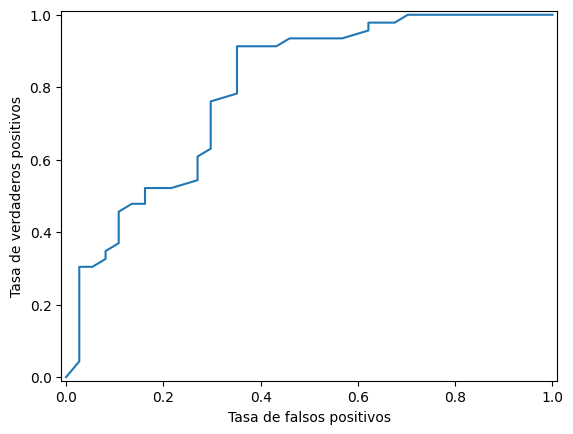

In [265]:
# Calculamos la probabilidad del modelo
prob_total = rand_for.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

In [266]:
# Usamos Gini como criterio 
rand_for_gini = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
rand_for_gini.fit(X_train, y_train)

# Predecimos los valores
y_hat = rand_for_gini.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

La matriz de confusión: 
 [[23 14]
 [10 36]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.70      0.62      0.66        37
         1.0       0.72      0.78      0.75        46

    accuracy                           0.71        83
   macro avg       0.71      0.70      0.70        83
weighted avg       0.71      0.71      0.71        83



Modelo con todos los atributos AUC: 0.7996474735605171


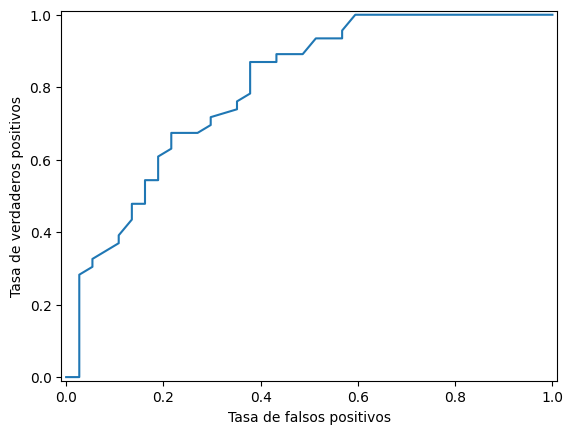

In [267]:
# Calculamos la probabilidad del modelo
prob_total_gini = rand_for_gini.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total_gini)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

 - Mejora el área bajo la curva roc con el criterio de gini.

## Adaboost classifier

In [268]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

AdaBoostClassifier()

In [269]:
# Predecimos los valores
y_hat = ada.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

La matriz de confusión: 
 [[19 18]
 [ 9 37]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.68      0.51      0.58        37
         1.0       0.67      0.80      0.73        46

    accuracy                           0.67        83
   macro avg       0.68      0.66      0.66        83
weighted avg       0.68      0.67      0.67        83



- Empeoró, pero probablemente se deba a que está mal aplicado.

## Aplicamos KNN Classifier

In [270]:
# Usamos los datos escalados para usar este tipo de clasificador
classifier_knn_total = KNeighborsClassifier(n_neighbors=9, metric="minkowski", p=2)
classifier_knn_total.fit(X_train_raw_scaled, y_train)

KNeighborsClassifier(n_neighbors=9)

La matriz de confusión: 
 [[14 23]
 [ 6 40]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.70      0.38      0.49        37
         1.0       0.63      0.87      0.73        46

    accuracy                           0.65        83
   macro avg       0.67      0.62      0.61        83
weighted avg       0.66      0.65      0.63        83

Modelo con todos los atributos AUC: 0.7212103407755581


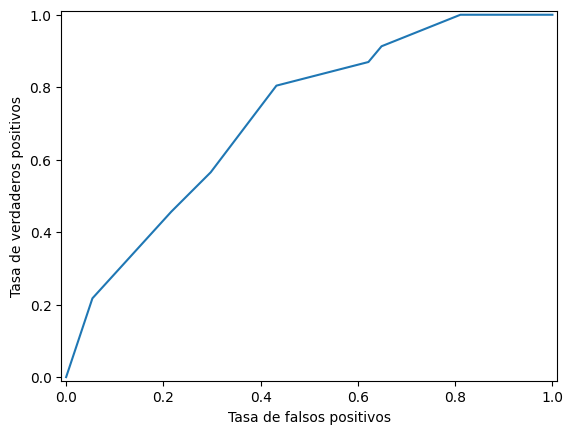

In [272]:
# Predecimos los valores
y_hat_KNN = classifier_knn_total.predict(X_test_raw_scaled)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat_KNN)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat_KNN)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total_KNN = classifier_knn_total.predict_proba(X_test_raw_scaled)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total_KNN)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- Elegimos un valor de 9 porque fue uno de los primeros valores mayores que obtuvimos. No es tan mal clasificador.

## Aplicamos SVM

In [273]:
from sklearn.model_selection import GridSearchCV

In [274]:
# Podemos aprovechar hacer una SVM lineal con gridsearch
svm_linear = SVC(kernel='linear', probability=True)

grid = GridSearchCV(svm_linear,
                    {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100]},
                    refit=True,
                    cv=5,
                    scoring='accuracy')
grid.fit(X_train_num_scaled, y_train)

# Vemos el mejor valor de parámetro
grid.best_params_

{'C': 1}

La matriz de confusión: 
 [[17 20]
 [ 7 39]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.71      0.46      0.56        37
         1.0       0.66      0.85      0.74        46

    accuracy                           0.67        83
   macro avg       0.68      0.65      0.65        83
weighted avg       0.68      0.67      0.66        83

Modelo con todos los atributos AUC: 0.7696827262044653


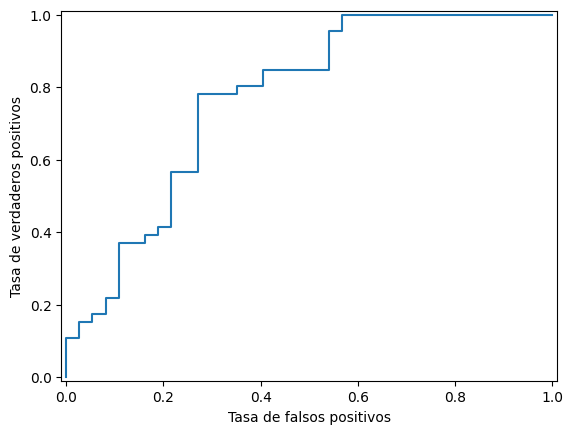

In [275]:
# Usamos para calcular el mejor estimador
svm_best = grid.best_estimator_

# Predecimos los valores
y_hat_svm = svm_best.predict(X_test_num_scaled)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat_svm)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat_svm)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total_svm = svm_best.predict_proba(X_test_num_scaled)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total_svm)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

In [276]:
# Podemos aprovechar hacer una SVM lineal con gridsearch
svm_linear = SVC(kernel='rbf', probability=True)

grid = GridSearchCV(svm_linear,
                    {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100]},
                    refit=True,
                    cv=5,
                    scoring='accuracy')
grid.fit(X_train_num_scaled, y_train)

# Vemos el mejor valor de parámetro
grid.best_params_

{'C': 1}

La matriz de confusión: 
 [[21 16]
 [ 5 41]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.81      0.57      0.67        37
         1.0       0.72      0.89      0.80        46

    accuracy                           0.75        83
   macro avg       0.76      0.73      0.73        83
weighted avg       0.76      0.75      0.74        83

Modelo con todos los atributos AUC: 0.7564629847238542


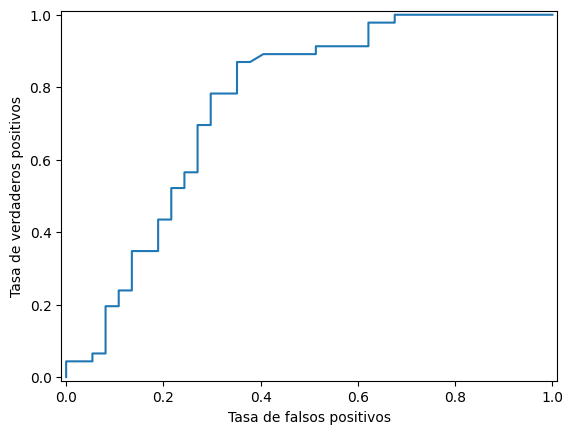

In [277]:
# Usamos para calcular el mejor estimador
svm_best = grid.best_estimator_

# Predecimos los valores
y_hat_svm = svm_best.predict(X_test_num_scaled)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat_svm)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat_svm)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total_svm = svm_best.predict_proba(X_test_num_scaled)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total_svm)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

## Feature selection
- Como tenemos que hacer una clasificación, vamos a usar el métodos de selección de feature: numérica-categórica y categórica-categórica.

In [278]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [279]:
def select_features_anova(X_train, y_train, X_test,k= 'all'):  
    fs = SelectKBest(score_func=f_classif, k=k )  
    fs.fit(X_train, y_train)  
    X_train_fs = fs.transform(X_train)  
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
def select_features_mi(X_train, y_train, X_test,k= 'all'):  
    fs = SelectKBest(score_func=mutual_info_classif, k=k )  
    fs.fit(X_train, y_train)  
    X_train_fs = fs.transform(X_train)  
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [280]:
playlist = playlist.drop('log_ac', axis=1)

### Numérica-Categórica

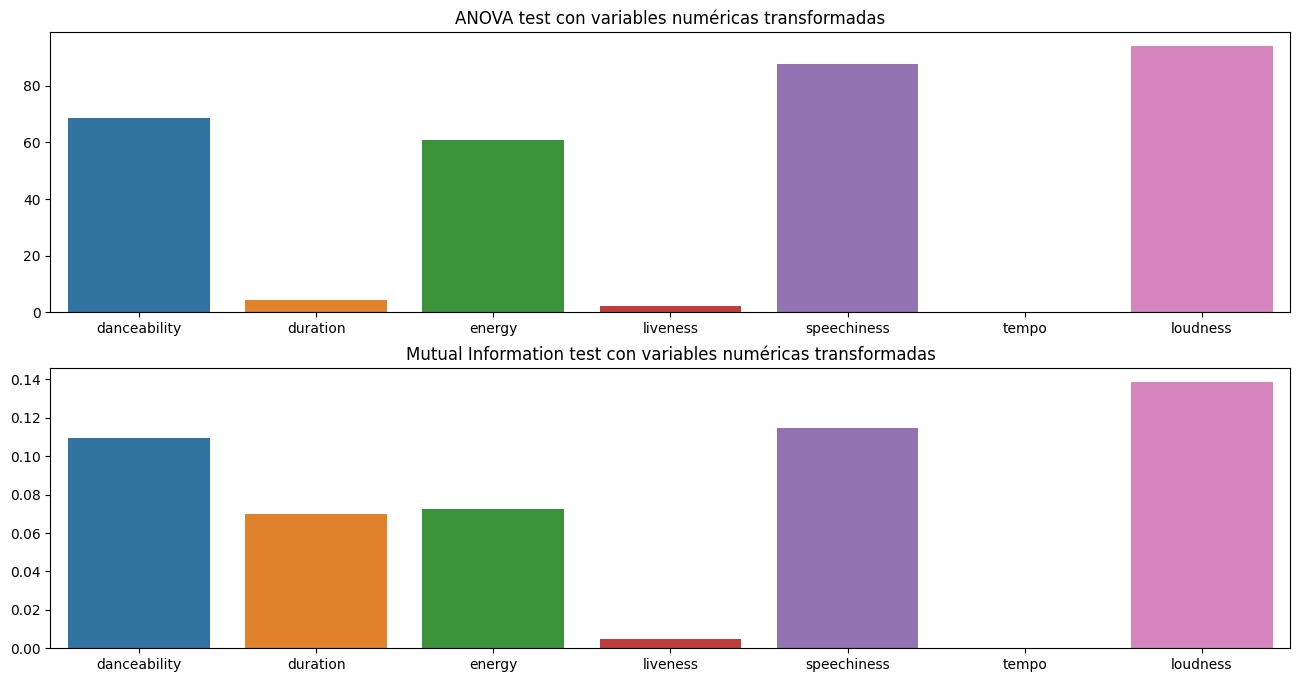

In [281]:
X_train_anova, X_test_anova, anova = select_features_anova(X_train_t, y_train, X_test_t)
fig,axes = plt.subplots(2,1,figsize=(16,8))
sns.barplot( x =X_train_t.columns.values, y = anova.scores_,ax=axes[0])
axes[0].set_title('ANOVA test con variables numéricas transformadas')

X_train_mi, X_test_mi, mi = select_features_mi(X_train_t, y_train, X_test_t)
sns.barplot( x =X_train_t.columns.values, y = mi.scores_,ax=axes[1])
axes[1].set_title('Mutual Information test con variables numéricas transformadas');

- Elegimos las variables que tengan mayor valor en ambos casos y comparamos con Reg.Log.
- Se va a quitar `loudness` ya que está fuertemente correlacionada con `energy`.

In [282]:
feat_select = ['danceability', 'energy', 'speechiness']

In [283]:
X_train_fs = X_train_t[feat_select]
X_test_fs = X_test_t[feat_select]

La matriz de confusión: 
 [[19 18]
 [ 8 38]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.70      0.51      0.59        37
         1.0       0.68      0.83      0.75        46

    accuracy                           0.69        83
   macro avg       0.69      0.67      0.67        83
weighted avg       0.69      0.69      0.68        83

Modelo con todos los atributos AUC: 0.7720329024676851


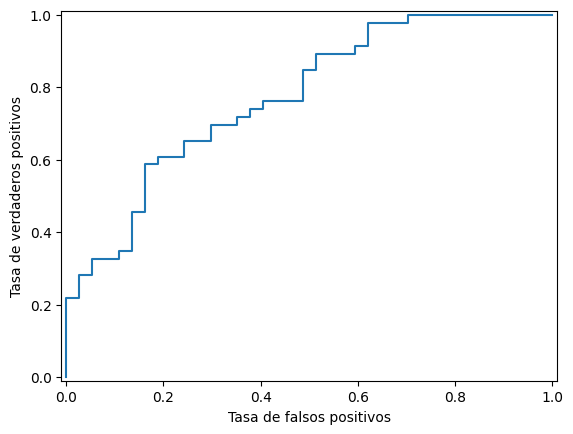

In [284]:
# Regresión logística
log_reg_fs = LogisticRegression()
log_reg_fs.fit(X_train_fs, y_train)

# Predecimos los valores
y_hat_fs = log_reg_fs.predict(X_test_fs)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat_fs)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat_fs)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total_fs = log_reg_fs.predict_proba(X_test_fs)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total_fs)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

La matriz de confusión: 
 [[22 15]
 [ 7 39]]


Reporte de clasificación: 
               precision    recall  f1-score   support

         0.0       0.76      0.59      0.67        37
         1.0       0.72      0.85      0.78        46

    accuracy                           0.73        83
   macro avg       0.74      0.72      0.72        83
weighted avg       0.74      0.73      0.73        83

Modelo con todos los atributos AUC: 0.7920094007050529


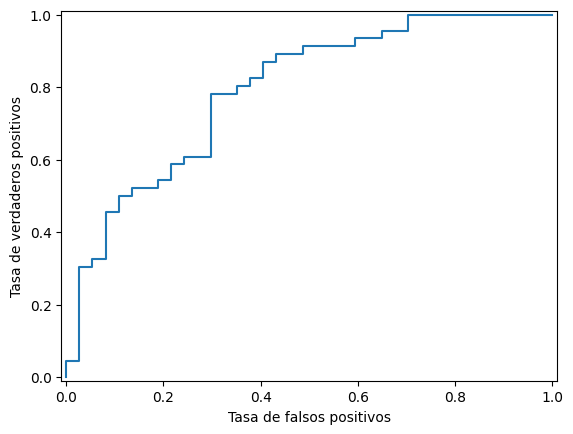

In [285]:
# SVM
svm_rbf_fs = SVC(kernel='rbf', probability=True)
svm_rbf_fs.fit(X_train_fs, y_train)

# Predecimos los valores
y_hat_svm_fs = svm_rbf_fs.predict(X_test_fs)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat_svm_fs)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat_svm_fs)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total_svm_fs = svm_rbf_fs.predict_proba(X_test_fs)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total_svm_fs)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")